In [1]:
import warnings
#to suppress seaborn palette warnings
warnings.filterwarnings("ignore", category=UserWarning)
#to suppress seaborn error estimation NaN warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

import os
import datetime

import numpy as np
import pandas as pd
import scipy
import scipy.stats as stats
import itertools

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates

#import matplotlib.spines as spines
from matplotlib.patches import Rectangle

from mouse_analysis_lib.loader import *
from lib.analysis_functions import *

#to suppress pandas reassignment false positive warnings
pd.options.mode.chained_assignment = None  # default='warn'

ModuleNotFoundError: No module named 'mouse_analysis_lib'

In [3]:
import mouse_analysis_lib

ModuleNotFoundError: No module named 'mouse_analysis_lib'

In [ ]:
lib.=

## 1. Load Files

### Parameters

In [ ]:
# directory files are pulled from
csv_directory = 'C:\\Users\\swind\\Documents\\lab_work\\Barth\\behavior_analysis\\Eunsol_data\\all_animals'
# directory to write output to (not implemented)
analysis_directory = 'C:\\Users\\swind\\Documents\\lab_work\\Barth\\behavior_analysis\\Eunsol_data\\refactor_4h'
# file containing information about animals (cage, age, sex, strain) - must have Animal ID column
metadata_file = 'C:\\Users\\swind\\Documents\\lab_work\\Barth\\behavior_analysis\\Eunsol_data\\eunsol_metadata.xlsx'

acc_col_name = 'acc'
default_acc_time = 1 # days

### Load metadata file

If no metadata, input an empty `.xlsx` file

In [ ]:
metadata = pd.read_excel(metadata_file)

In [ ]:
# this will load all conditions in a directory of multiple conditions
df = []
for d in os.listdir(csv_directory):
    cond = make_condition_df(csv_directory +'\\' + d, d, metadata, acc_col_name, default_acc_time)
    df.append(cond)
df = pd.concat(df)

NKZ4: no metadata
NLB1: no metadata
OEP2: no metadata
OEP5: no metadata
OIJ6: no metadata
ONW8-recheck training: no metadata
OPY5: no metadata


In [ ]:
#filter unwanted condition(s)
df = df[df["condition"] != "dcz_05"]
df = df[df["condition"] != "all_reward"]

## 2. Lick Frequency Analysys

### Parameters

In [ ]:
time_bin = 4*60 # minutes
# using rolling window
freq_window = 100 # milliseconds, width of rolling window
freq_bin = 100 # milliseconds, width of discrete time bin

### a. Lick frequency across entire trial

In [ ]:
data = lickfreq_analysis(df, freq_window, freq_bin, time_bin)

### b. Just anticipatory likcing

In [ ]:
ant_data = bin_lickfreq_analysis(df, (700, 1000), time_bin)

## 3. Pre-aggregate analysis (optional)

### a. Group trials into bouts

Bout boundaries are defined as 2 consecutive trials being more than 2 minutes
apart, based on visual investigation of raster plots of 
trial distributions of individual animals.

In [ ]:
data = get_bouts(data, ["animal"], "timestamp", "bout no", 2, "min")

### b. Label trials with previous trial identity

Uses bout labels to only look at previous trials within a bout (i.e. that 
happened less than 2 minutes before the current trial).

In [ ]:
trial_ind = ["animal", "trial no"]
bout_ind = ["animal", "bout no"]
key = "stimulus"
n = 1
cond0 = "stimulus"
cond1 = "blank"
data = get_n_back(data, trial_ind, bout_ind, key, n, cond0, cond1)

### c. Get trials in given quintile of day

In [ ]:
# not implemented
nth_quint = 4 # which quintile (20%) of trials to keep (numbered 0-4)


## 4. Aggregate values

### Parameters for aggregation

In [ ]:
min_trials = 10 # minimum number of trials in a bin to keep
min_water_trials = 0 # minimum number of water trials
min_blank_trials = 0 # minimum number of water trials

### Calculate aggregate Values

In [ ]:
mean_statistics, counts, perf = aggregate_analysis(data, min_trials, min_blank_trials, min_water_trials, ["day_delta"])

### Calculate aggregate values filtered by previous trial identity

untested for `n` $\geq$ `1`

In [ ]:
n = 1
mean_w_prev, counts_w_prev, perf_w_prev = agg_by_prev_trial(data, (mean_statistics, counts, perf), n, min_trials, min_blank_trials, min_water_trials, ["type"])

### Calculate aggregate values for just anticipatory licking

In [ ]:
ant_mean_statistics, ant_counts, ant_perf = bin_aggregate_analysis(ant_data, min_trials, min_blank_trials, min_water_trials, [])

### Number of animals in each bin

In [ ]:
num_per_timebin = counts.groupby(["condition", "animal", "Time (hr)"]).first().reset_index().groupby(["condition","Time (hr)"])["animal"].count().reset_index().set_index(["condition", "Time (hr)"]).unstack("condition").reset_index()
num_per_timebin[(num_per_timebin["Time (hr)"] < 24) & (num_per_timebin["Time (hr)"] >= -24)].set_index("Time (hr)")

animal                      
condition    SAT hm4di_cno mcherry_cno
Time (hr)                             
-24.0        8.0       5.0        12.0
-20.0        9.0       9.0        13.0
-16.0       14.0      12.0        14.0
-12.0       14.0      12.0        14.0
-8.0        14.0      11.0        13.0
-4.0         9.0      11.0        10.0
 0.0         7.0       9.0         8.0
 4.0         9.0      11.0        14.0
 8.0        13.0      12.0        14.0
 12.0       14.0      12.0        14.0
 16.0       11.0      12.0        13.0
 20.0        7.0       8.0         9.0

### Rate of Change of licking across trial

In [ ]:
tmp = perf.groupby(["condition", "Time (hr)", "Time (ms)"])["lick"].mean().unstack(level=["condition", "Time (hr)"])
tmp.diff


<bound method DataFrame.diff of condition       SAT                                                    \
Time (hr)     -48.0     -44.0     -40.0     -36.0     -24.0     -20.0   
Time (ms)                                                               
-200.0     0.893082  0.454545  0.884009 -1.111111  0.377667  0.034219   
-100.0    -0.013477 -0.492424  0.067173 -0.573034  0.501136 -0.064962   
 0.0       1.500000  0.454545  1.034583 -0.555556  0.860222 -0.142888   
 100.0     0.528302 -1.401515  0.536124 -1.000000 -0.115389 -0.799005   
 200.0     1.937107 -0.562771  1.100788 -1.148325  0.200924 -0.556380   
 300.0     1.679487 -2.045455  1.153734 -1.722222  0.125947  0.111948   
 400.0     2.125786 -0.492424  1.814893 -0.739208  0.445833  0.051557   
 500.0     2.448718 -0.562771  1.720158  0.000000  0.813467 -0.094277   
 600.0     2.538462 -1.098485  1.218463  1.187271  0.331207  0.365243   
 700.0     1.748428 -1.098485  1.269707  0.277778  0.214680  0.550172   
 800.0     2.503145

## 5. Plots parameters

Will need tweaking/cleaning for 

1. each plot 

1. each use of plots (powerpoint, poster, etc.)

1. each set of conditions

### matplotlib style sheet

In [ ]:
mpl.style.use(r"C:\Users\swind\Documents\lab_work\Barth\behavior_analysis\mouse_analysis\users\rswind\mouse_analysis_app\custom.mplstyle")

### Parameters

In [ ]:
cond_dict = {"SAT":"Control", "all_reward":"100% acclimation, 80% SAT", "hm4di_cno":"hM4Di plus CNO", "mcherry_cno":"mCherry plus CNO"}
cond_ordr = ["SAT", "hm4di_cno", "mcherry_cno"]

prev_dict = {('stimulus', 'blank'): "stimulus then blank",
       ('stimulus', 'stimulus'): "stimulus then stimulus", 
       ('blank', 'blank'):"blank then blank",
       ('blank', 'stimulus'): "blank then stimulus"}
prev_palette = ["xkcd:burgundy", "xkcd:british racing green", "xkcd:magenta", "xkcd:turquoise green"]
prev_ordr = [('stimulus', 'blank'),
             ('stimulus', 'stimulus'), 
             ('blank', 'blank'),
             ('blank', 'stimulus')]

type_dict = {"sat":"SAT", "cno":"CNO"}

sat_fill = "#D6D9F6"
sat_line = "#5E72FF"
hmd4i_fill = "#F7E3BD"
hm4di_line = "goldenrod" # desat version: "#D8981A"
mch_line = "maroon" # desat version: "#842424" 
cond_palette = [sat_line, hm4di_line, mch_line]


stim_fill = "#B2D9B2"
blank_fill = "#FFB2B2"
water_c = "#BBE9FD"

### Style functions

In [ ]:
# from jsgounot on stackoverflow (https://stackoverflow.com/questions/34888058/changing-width-of-bars-created-with-catplot-or-barplot)
def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width + new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)

def move_leg(fig, fontsize):
    try:
        sns.move_legend(fig, "center right", bbox_to_anchor=(1.02,0.5), 
                        fontsize=fontsize, title_fontsize=fontsize)
        #plt.setp(ax.get_legend().get_texts(), fontsize='22') # for legend text
        #plt.setp(ax.get_legend().get_title(), fontsize='32') # for legend title

    except ValueError:
        pass

def style_axes(ax, ylims, xlims, ylabel, xlabel, t, label_fontsize, tick_fontsize, titlepad=None, yticklabels=True):
    if titlepad != None:
        ax.set_title(t, fontsize=label_fontsize, pad=titlepad)
    else:
        ax.set_title(t, fontsize=label_fontsize)
    ax.set_ylabel(ylabel, fontsize=label_fontsize)
    ax.set_xlabel(xlabel, fontsize=label_fontsize) 
    ax.set_xticks(ax.get_xticks(), labels=ax.get_xticklabels(), fontsize=tick_fontsize)
    if yticklabels:
        ax.set_yticks(ax.get_yticks(), labels=ax.get_yticklabels(), fontsize=tick_fontsize)
    else:
        ax.set_yticks(ax.get_yticks(), labels=[], fontsize=tick_fontsize)
    ax.set_ylim(ylims)
    ax.set_xlim(xlims)

def style_catplot_hr(fig, ylims, ylabel, name_dict, label_sat=True, labely=True):
    xlims=[-27, 24]
    x_mult = 12
    y_mult = int(ylims[1]/2)

    fig.figure.subplots_adjust(hspace=0.15, wspace=0.35)
    for name, ax in fig.axes_dict.items():
        t = name_dict[name]
        ax.axhline(y=0, xmin=0, xmax=1, ls="-", color="black", zorder=10, lw=1)
        
        if(label_sat):
            # sat (only works for 24 of sat)
            ax.add_patch(Rectangle((-1.7, ylims[0]), xlims[1], xlims[1]/2, color=sat_fill, alpha=1, 
                                zorder=0, fill=True))
            
        ymax = ylims[1]
        ax.set_ylim(ylims)
        ax.xaxis.set_major_locator(ticker.MultipleLocator(x_mult))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(y_mult))
        ax.xaxis.set_minor_locator(ticker.MultipleLocator(x_mult/3))
        ax.yaxis.set_minor_locator(ticker.MultipleLocator(y_mult/2))
        style_axes(ax, ylims, xlims,ylabel, "Time (hr)", t, "large", "small")
 
def style_relplot_ms(fig, ylims, ylabel, name_dict):
    air_start = 0
    air_width = 500
    water = 1000

    x_mult = 500
    x_off = 0
    xlims=[-220, 2000]
    #y_fixed = int(ylims[1]/2)
    fig.figure.subplots_adjust(hspace=0.85, wspace=0.35)
    i=0
    for name, ax in fig.axes_dict.items():
        if type(name) is tuple:
            row_val, col_val = name
            t = f'{row_val} hr'
        else:
            t = name_dict[name]
        
        # line at 0
        ax.axhline(y=0, xmin=0, xmax=1, ls="-", color="black", zorder=10, lw=1)
        # duration of air puff
        ax.add_patch(Rectangle((0, ylims[0]), 500, ylims[1], color="lightgrey", alpha=0.2, 
                               zorder=0, fill=True))        
        # water delivery
        ax.add_patch(Rectangle((1005, ylims[0]), 100, ylims[1], color=water_c, alpha=0.8, 
                               zorder=0, fill=True))
        ax.set_ylim(ylims)
        ax.xaxis.set_major_locator(ticker.MultipleLocator(x_mult, offset=x_off))
        ax.yaxis.set_major_locator(ticker.LinearLocator(numticks=3))
        ax.xaxis.set_minor_locator(ticker.MultipleLocator(x_mult/3))
        ax.yaxis.set_minor_locator(ticker.LinearLocator(numticks=7))
        style_axes(ax, ylims, xlims,"", "Time (ms)", t, "x-large", "large")
        move_leg(fig, "small")
        i+=1

def style_relplot_hr(fig, ylims, ylabel, name_dict, label_sat=True, ymultmin=3):
    xlims=[-24.5, 24]
    x_mult = 12
    y_mult = ylims[1]/2

    fig.figure.subplots_adjust(hspace=0.55, wspace=0.35)
    if len(fig.axes_dict.items()) > 0:
        for name, ax in fig.axes_dict.items():
            if type(name) is tuple:
                row_val, col_val = name
                t = f'{row_val} at {col_val}'
            else:
                t = name_dict[name]
            # line at 0
            ax.axhline(y=0, xmin=0, xmax=1, ls="-", color="black", zorder=1, lw=1)
            if(label_sat):
                # sat (only works for 24 sat)
                ax.add_patch(Rectangle((0, ylims[0]), 24, 12, color=sat_fill, alpha=0.4, 
                                    zorder=-1, fill=True))
                ax.set_ylim(ylims)                
            ax.xaxis.set_major_locator(ticker.MultipleLocator(x_mult))
            ax.yaxis.set_major_locator(ticker.LinearLocator(numticks=3))
            ax.xaxis.set_minor_locator(ticker.MultipleLocator(x_mult/3))
            ax.yaxis.set_minor_locator(ticker.LinearLocator(numticks=7))
            style_axes(ax, ylims, xlims,ylabel, "Time (hr)", t, "x-large", "large")
            move_leg(fig, "large")
    else:
        ax = fig.fig.axes[0]
        # line at 0
        ax.axhline(y=0, xmin=0, xmax=1, ls="-", color="black", zorder=1, lw=1)
        if(label_sat):
            # sat (only works for 24 sat)
            ax.add_patch(Rectangle((0, ylims[0]), 24, 12, color=sat_fill, alpha=0.8, 
                                zorder=-1, fill=True))
            ax.set_ylim(ylims)                
        ax.xaxis.set_major_locator(ticker.MultipleLocator(x_mult))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(y_mult))
        ax.xaxis.set_minor_locator(ticker.MultipleLocator(x_mult/3))
        ax.yaxis.set_minor_locator(ticker.MultipleLocator(y_mult/ymultmin))
        style_axes(ax, ylims, xlims,ylabel, "Time (hr)", "", "x-large", "large")
        move_leg(fig, "large")


## 6. Plots

### Anticipatory licking frequency

By directly calculating anticipatory licking frequency

Text(1200.5555555555559, 0.5, '')

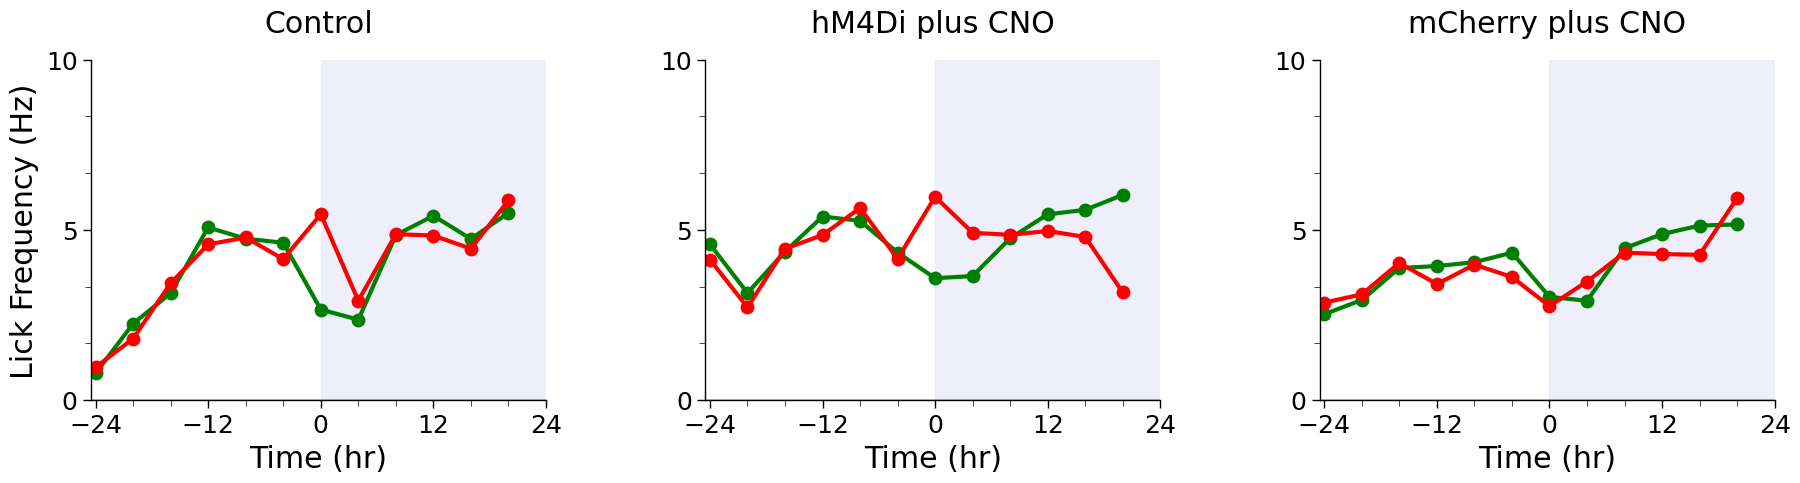

In [ ]:
# above approach is valid - this produces (almost) exactly the same plot# anticipatory licking
cond = (ant_mean_statistics["Time (hr)"] < 24) & (ant_mean_statistics["Time (hr)"] >= -24)
g = sns.relplot(ant_mean_statistics[cond], x="Time (hr)", y="lick", hue="stimulus", 
                col ="condition", palette = ["green", "red"], errorbar=None,
                hue_order=["stimulus", "blank"], kind="line",  aspect=1.2, 
                facet_kws={"sharey":False}, marker='o', mec=None,ms=10, 
                legend=False)
style_relplot_hr(g, [0,  10], "Lick Frequency (Hz)", cond_dict)
g.axes_dict["hm4di_cno"].set_ylabel("")
g.axes_dict["mcherry_cno"].set_ylabel("")

#### anticipatory licking to stimulus bar plot

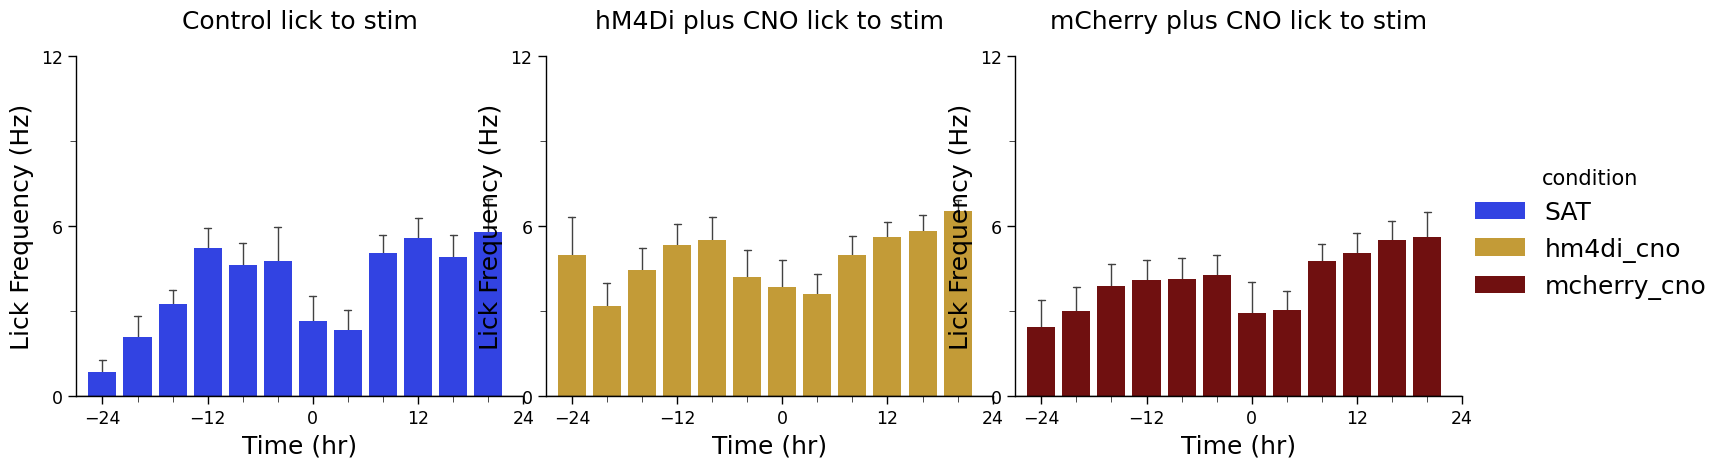

In [ ]:
# anticipatory licking to stimulus
ant = mean_statistics[(mean_statistics["Time (ms)"] == 900)] 
cond = (ant["Time (hr)"] < 24) & (ant["Time (hr)"] >= -24) & (ant["stimulus"] == "stimulus")
 
g = sns.catplot(ant[cond], x="Time (hr)", y="lick",
                hue="condition", col ="condition", palette = cond_palette, 
                kind="bar", errorbar="se", dodge=False, capsize=0.2,
                hue_order=cond_ordr, err_kws={"zorder":0, "lw":1},
                sharey=False, sharex=False, native_scale=True)

stim_dict =  {key:cond_dict[key] + " lick to stim" for key in cond_dict.keys()}
style_catplot_hr(g, [0, 12],"Lick Frequency (Hz)", stim_dict, label_sat=False)


#### anticipatory licking to blank bar plot

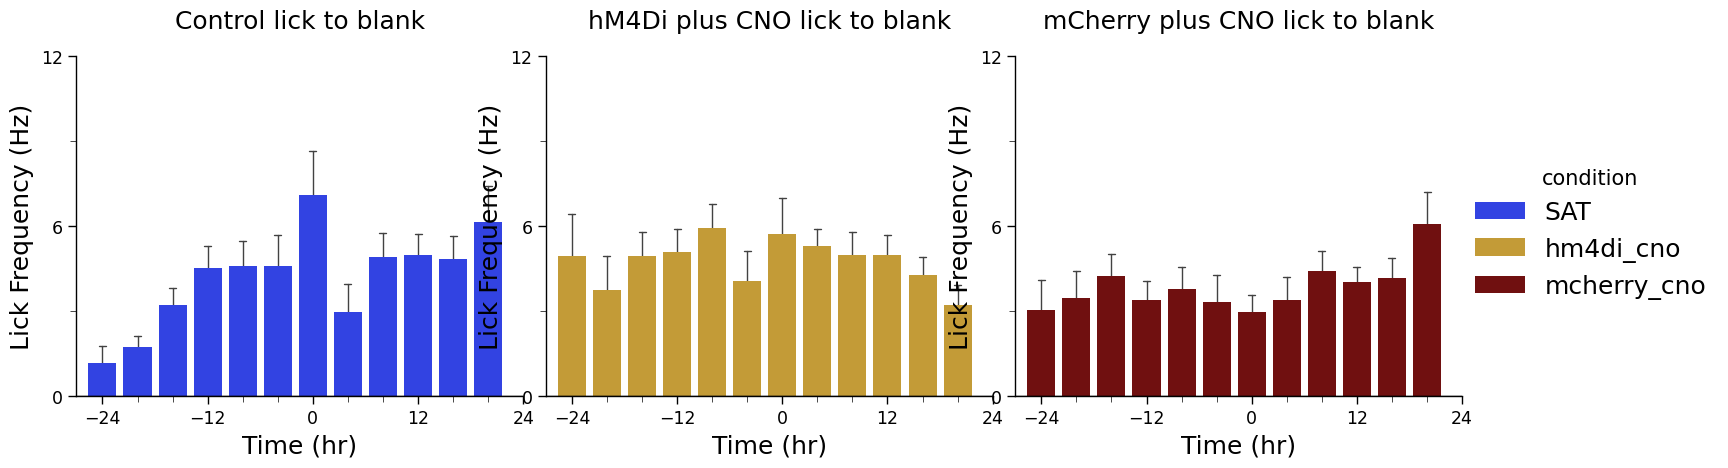

In [ ]:
# anticipatory licking to blank
ant = mean_statistics[(mean_statistics["Time (ms)"] == 900)] 
cond = (ant["Time (hr)"] < 24) & (ant["Time (hr)"] >= -24) & (ant["stimulus"] == "blank")
 
g = sns.catplot(ant[cond], x="Time (hr)", y="lick",
                hue="condition", col ="condition", palette = cond_palette, 
                kind="bar", errorbar="se", dodge=False, capsize=0.2,
                hue_order=cond_ordr, err_kws={"zorder":0, "lw":1},
                sharey=False, sharex=False, native_scale=True)

blank_dict =  {key:cond_dict[key] + " lick to blank" for key in cond_dict.keys()}
style_catplot_hr(g, [0, 12],"Lick Frequency (Hz)", blank_dict, label_sat=False)

### Performance

#### performance line plot


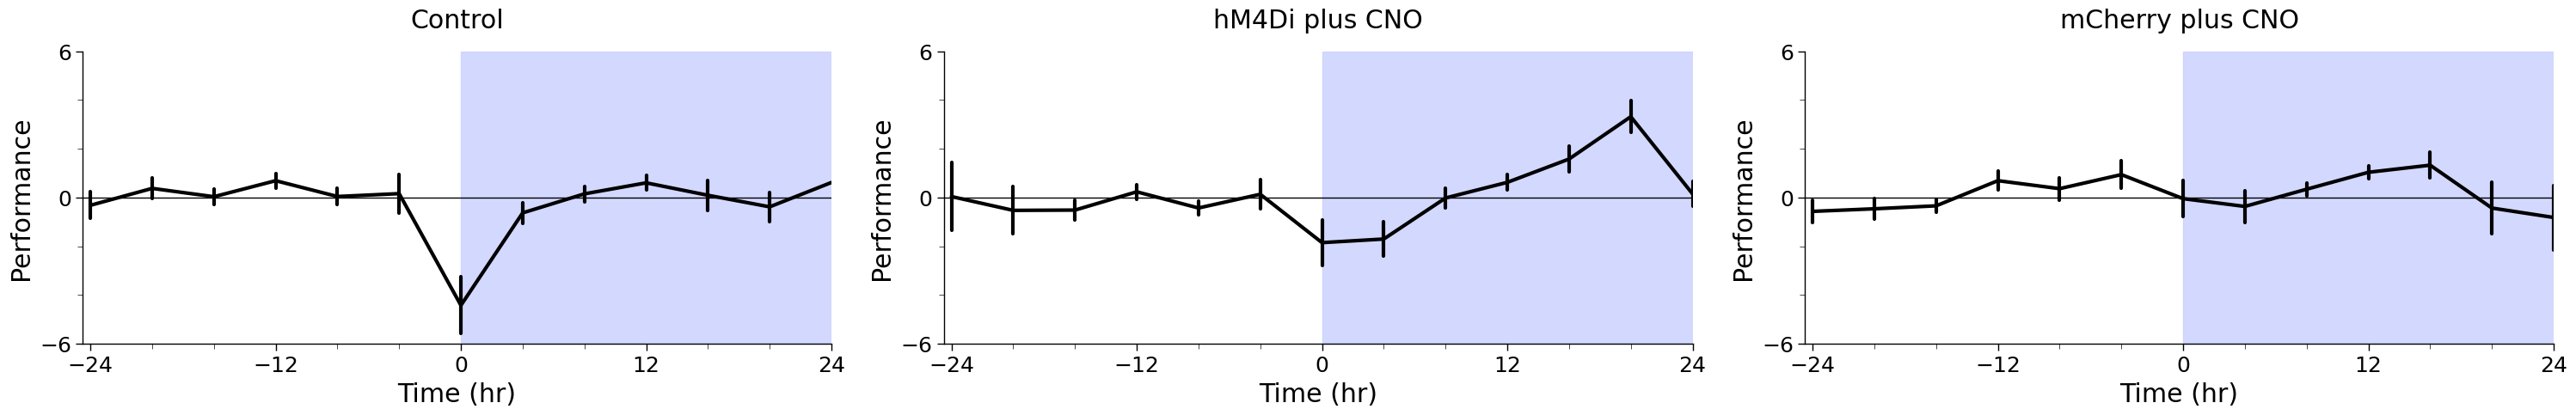

In [ ]:
# performance line plot
ant = perf[(perf["Time (ms)"] == 900)] 
cond = (ant["Time (hr)"] <= 24) & (ant["Time (hr)"] >= -24)
g = sns.relplot(ant[cond], x="Time (hr)", y="lick", col ="condition",
                kind="line", errorbar="se", err_style="bars", aspect=2, 
                facet_kws={"sharey":False}, color='k')
style_relplot_hr(g, [-6,6], "Performance", cond_dict, "hr")


#### performance bar plot


'a'

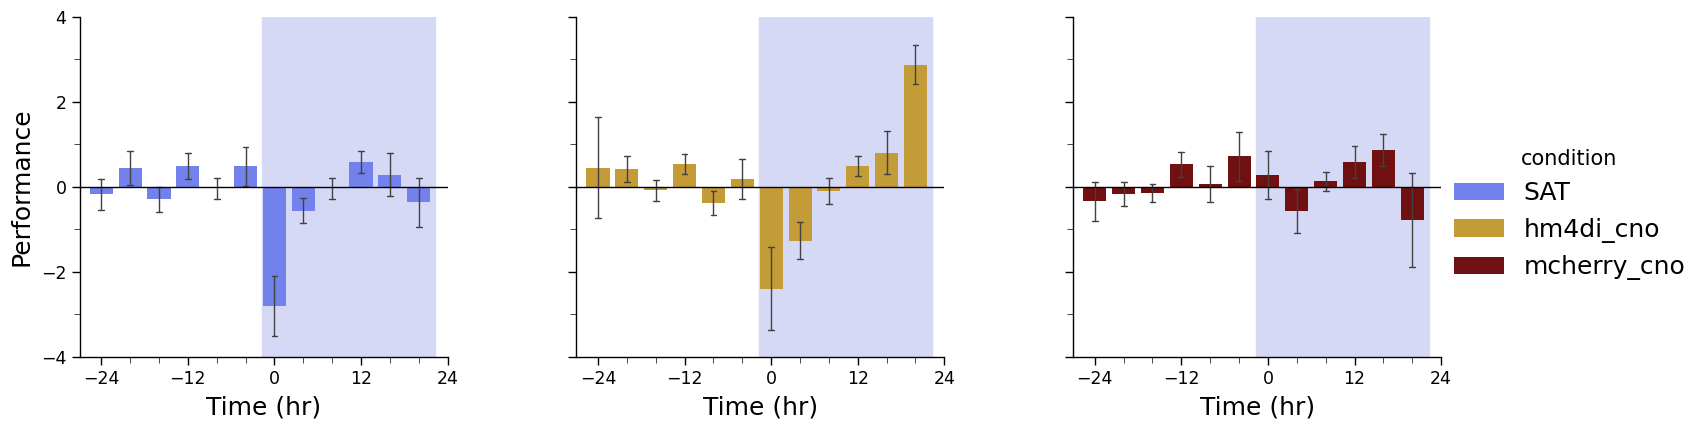

In [ ]:
# performance bar plot
cond = (ant_perf["Time (hr)"] < 24) & (ant_perf["Time (hr)"] >= -24)

g = sns.catplot(ant_perf[cond], x="Time (hr)", y="lick", aspect=1,
                hue="condition", col ="condition", palette = cond_palette, 
                kind="bar", errorbar="se", dodge=False, capsize=0.2,
                hue_order=cond_ordr, err_kws={"zorder":1, "lw":1},
                sharex=False, sharey=False, native_scale=True)

e_dict = {"SAT":"", "all_reward":"", "hm4di_cno":"", "mcherry_cno":""}

style_catplot_hr(g, [-4,4], "Performance", e_dict, label_sat=True)
plt.setp([g.axes_dict["mcherry_cno"].get_yticklabels(), g.axes_dict["hm4di_cno"].get_yticklabels()], visible=False)
g.axes_dict["mcherry_cno"].set_ylabel("") 
g.axes_dict["hm4di_cno"].set_ylabel("")
'a'

#### performance across trial (all timebins in one plot)


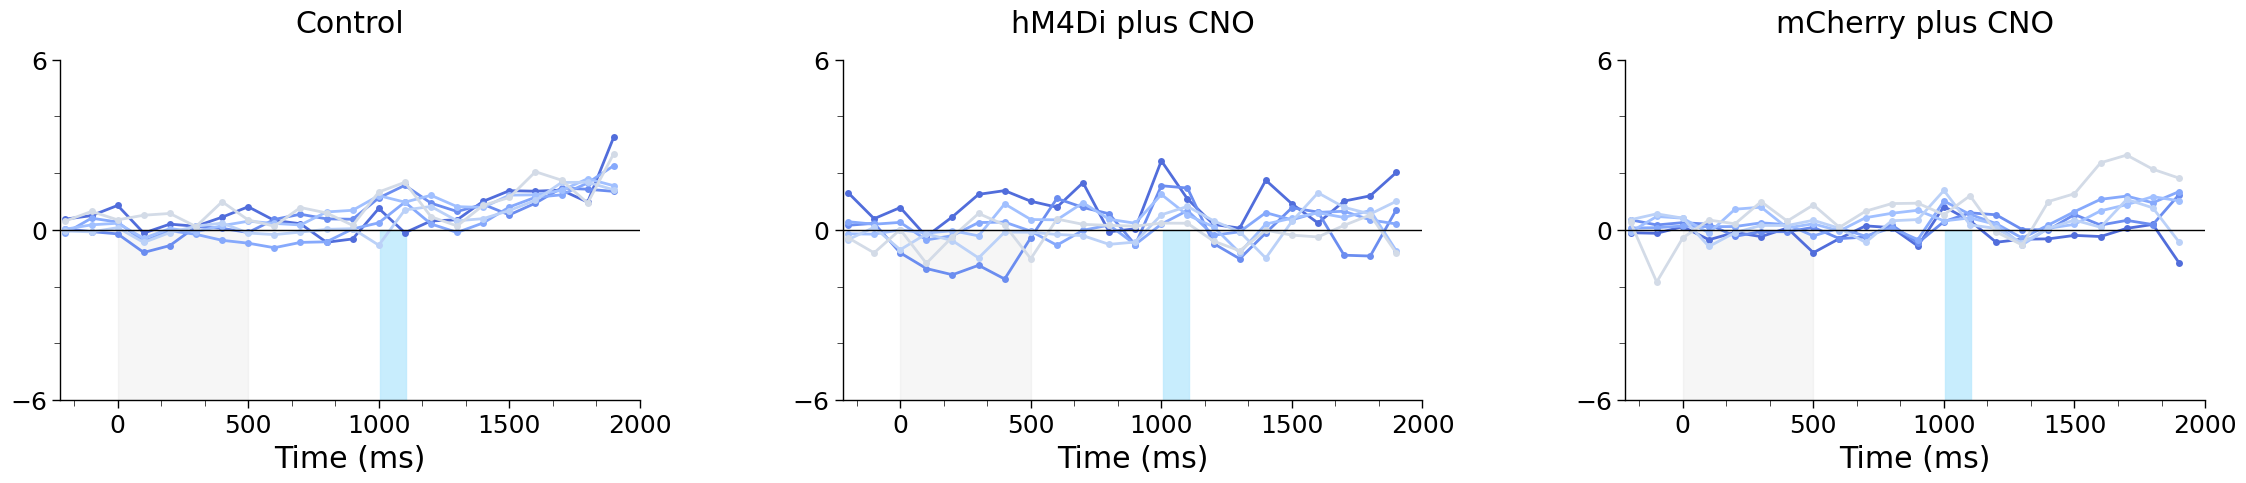

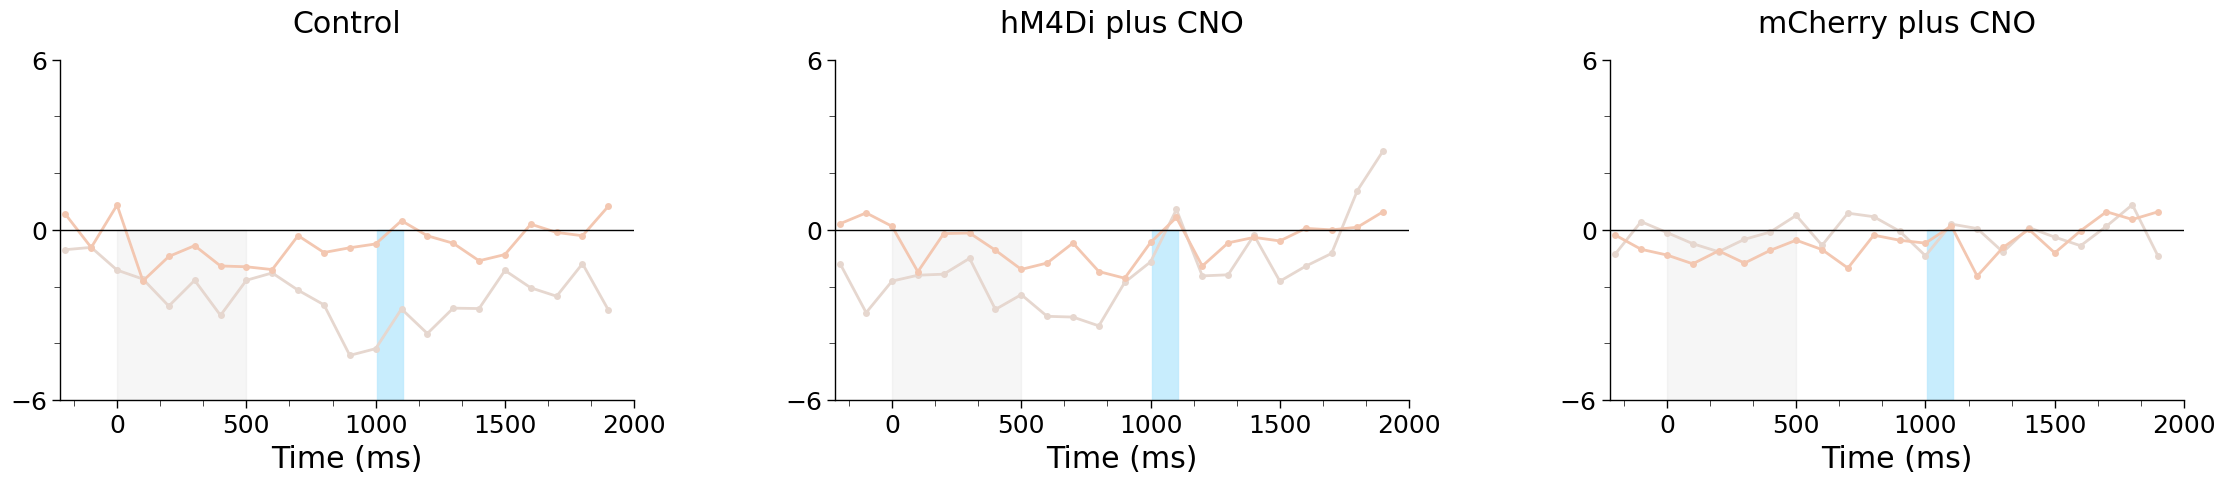

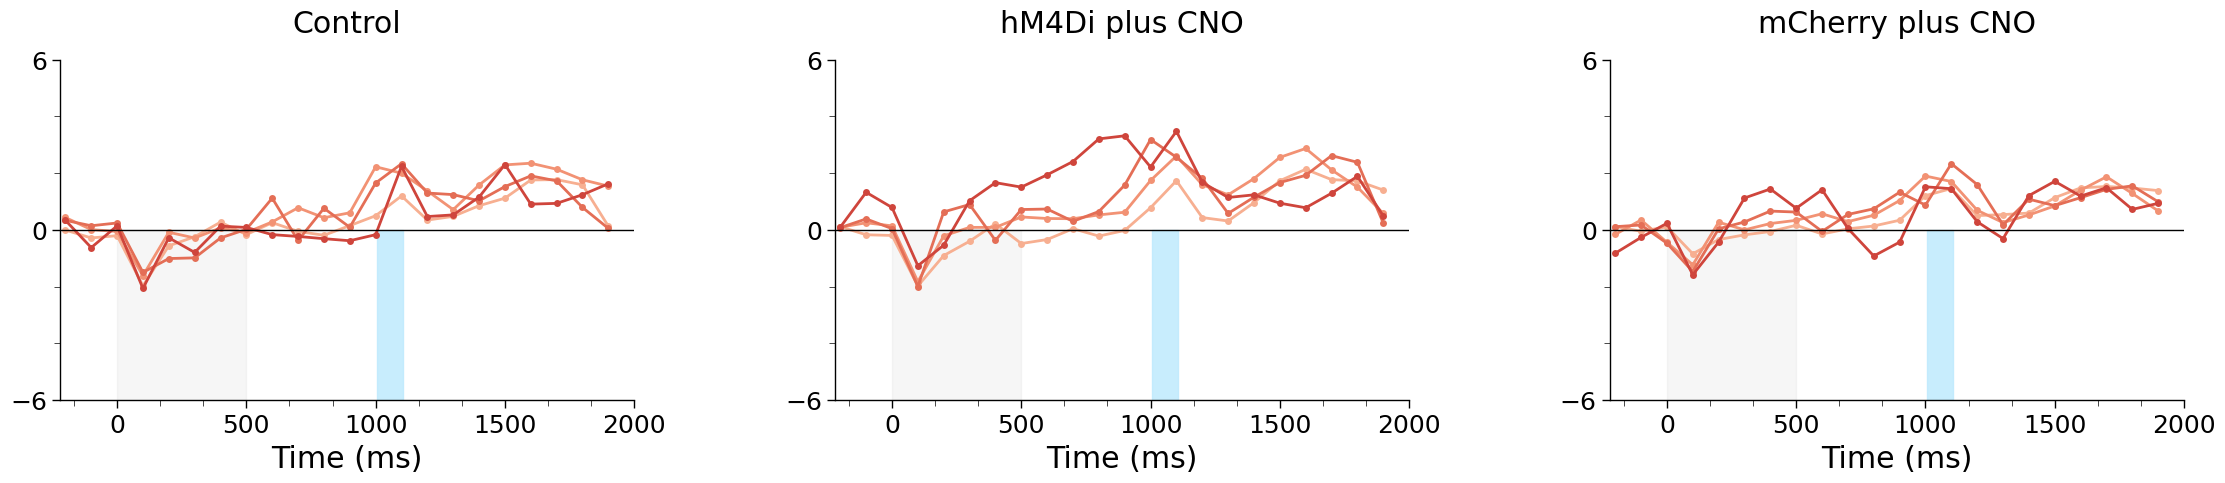

In [ ]:
# performance across trial (all timebins in one plot)
pl = sns.color_palette("coolwarm", n_colors=12)
condacc = ( (perf["Time (hr)"] < 0) & (perf["Time (hr)"] >= -24) )
condearly = ( (perf["Time (hr)"] < 8) & (perf["Time (hr)"] >= 0) )
condlate = ( (perf["Time (hr)"] < 24) & (perf["Time (hr)"] >= 8) )

g = sns.relplot(data=perf[condacc], kind="line",x="Time (ms)", y="lick",
                col="condition", hue="Time (hr)", palette=pl[0:6],
                legend=False, errorbar=None, lw=2, marker='o', mec=None,
                facet_kws={"sharex":False, "sharey":False}, aspect=1.5
)

style_relplot_ms(g, [-6,6], "Performance", cond_dict)

g = sns.relplot(data=perf[condearly], kind="line",x="Time (ms)", y="lick",
                col="condition", hue="Time (hr)", palette=pl[6:8],
                legend=False,  errorbar=None,lw=2,marker='o', mec=None,
                facet_kws={"sharex":False, "sharey":False}, aspect=1.5)
style_relplot_ms(g, [-6,6], "Performance", cond_dict)


g = sns.relplot(data=perf[condlate], kind="line",x="Time (ms)", y="lick",
                col="condition", hue="Time (hr)", palette=pl[8:],
                legend=False,  errorbar=None,lw=2, marker='o', mec=None,
                facet_kws={"sharex":False, "sharey":False}, aspect=1.5)
style_relplot_ms(g, [-6,6], "Performance", cond_dict)


#### performance across trial by hour, conditions together


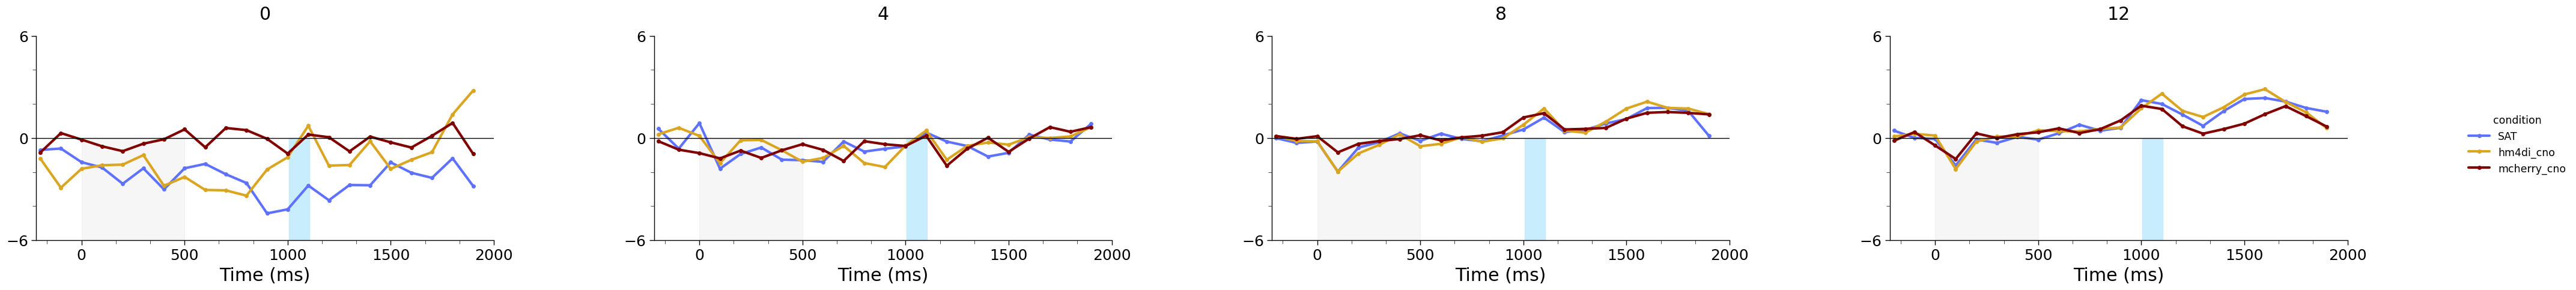

In [ ]:
# performance across trial by hour, conditions together
cond = ( (perf["Time (hr)"] >= 0) & (perf["Time (hr)"] <= 12) )
g = sns.relplot(data=perf[cond], kind="line",x="Time (ms)", y="lick",col="Time (hr)", 
                    hue="condition", palette=cond_palette,errorbar=None,
                    marker='o', mec=None, aspect=2,
                    facet_kws={"sharex":False, "sharey":False} )
t_dict = {k:k for k in range(-24, 24, 4)}
style_relplot_ms(g, [-6,6], "Performance", t_dict)

### Number of Trials

#### bar plot by day


'a'

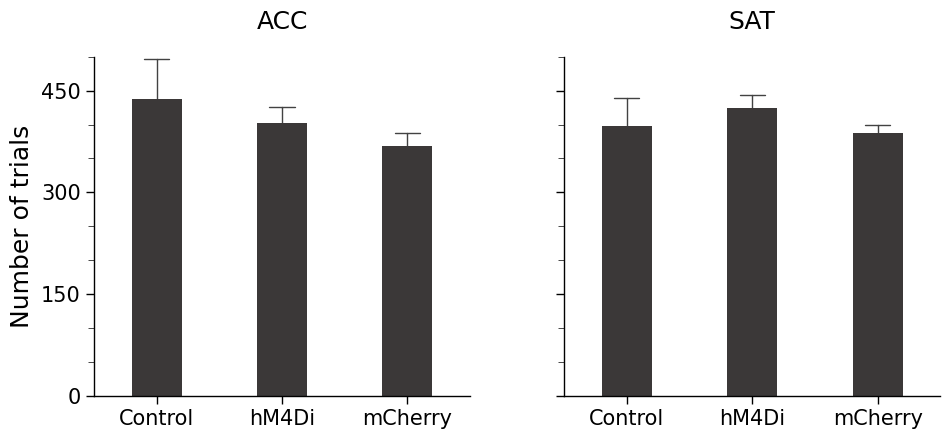

In [ ]:
# bar plot by day
total_trials = counts.groupby(["condition", "type", "animal", "day_delta"]).sum()["trial no"].reset_index()
time_to_float(total_trials, "Day", "day_delta", "D")
cond = (total_trials["Day"] > -2) & (total_trials["Day"] < 1)

#total_trials.loc[total_trials["condition"] == "hm4di_cno"] = cond_dict["hm4di_cno"]
#total_trials.loc[total_trials["condition"] == "mcherry_cno"] = cond_dict["mcherry_cno"]

g = sns.catplot(total_trials[cond], x="condition", y="trial no", aspect=1,
                col ="Day", color='#3B3838', sharey=False, capsize=0.2,
                kind="bar", errorbar="se", err_kws={"lw":1, "zorder":0},
                width=0.4)

cond_dict = {"SAT":"SAT", "all_reward":"100% acclimation, 80% SAT", "hm4di_cno":"hM4Di plus CNO", "mcherry_cno":"mCherry plus CNO"}
time_dict = {-1:"ACC", 0:"SAT"}
xlims = [-0.5, 2.5]
ylims = [200, 650]
ylabel = "Number of trials"
for (col_val), ax in g.axes_dict.items():
    t=f"{time_dict[col_val]}"
    ax.set_xticklabels(["Control", "hM4Di", "mCherry"], fontsize='large')
    ax.yaxis.set_major_locator(ticker.MultipleLocator(150))
    ax.yaxis.set_minor_locator(ticker.MultipleLocator(50))
    ax.tick_params(which='minor', size=4)
    style_axes(ax, [0, 500], xlims, ylabel, "", t, "large", "medium")
g.figure.subplots_adjust(wspace=0.25)

g.axes_dict[0].set_ylabel("")
plt.setp([g.axes_dict[0].get_yticklabels()], visible=False)
'a'

#### number of total trials line plot

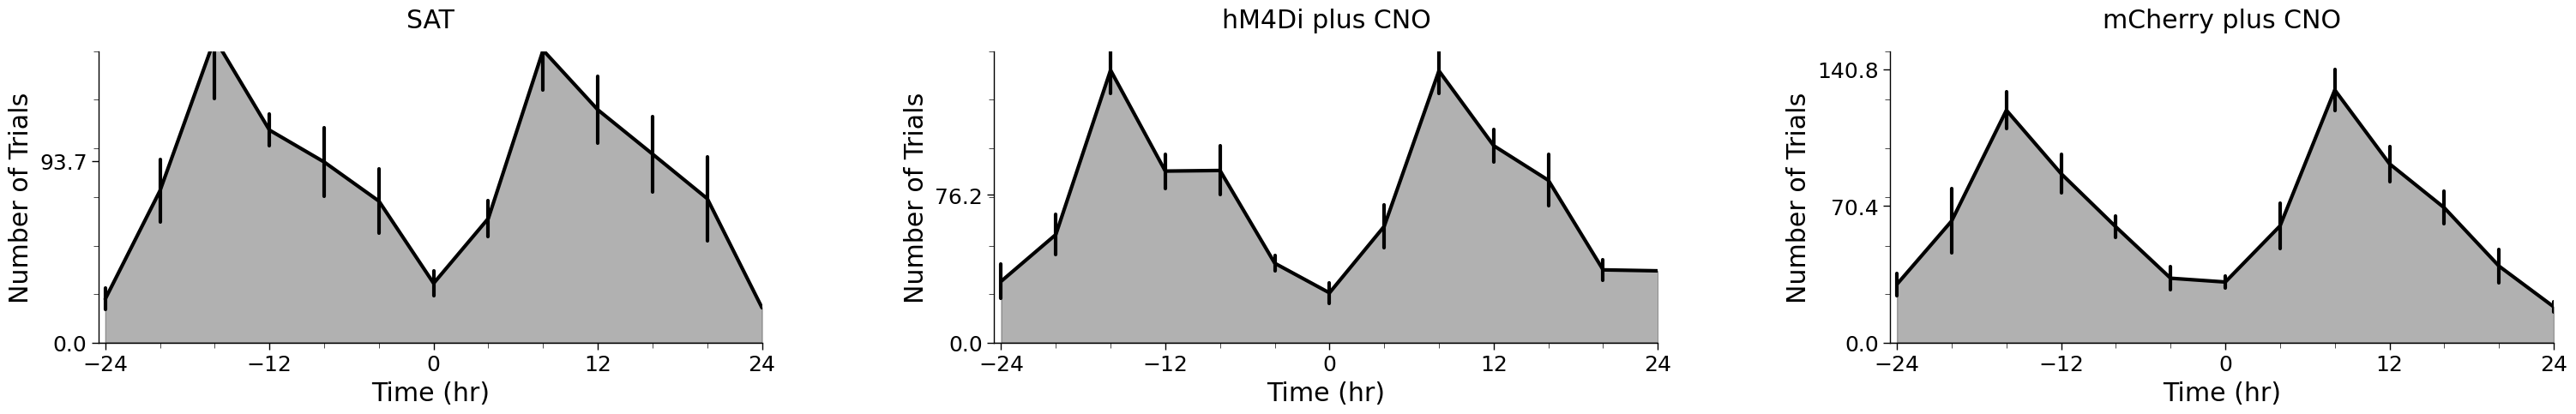

In [ ]:
# number of total trials
tt_hr = counts.groupby(["condition", "type", "animal", "Time (hr)"]).sum()["trial no"].reset_index()
cond = (tt_hr["Time (hr)"] <= 24) & (tt_hr["Time (hr)"] >= -24)
g = sns.relplot(tt_hr[cond], x="Time (hr)", y="trial no", col ="condition",
                kind="line", errorbar="se", err_style="bars", aspect=2, 
                facet_kws={"sharey":False}, color='k')
style_relplot_hr(g, [0, 150], "Number of Trials", cond_dict, label_sat=False)
for name, ax in g.axes_dict.items():
    ax.fill_between(ax.lines[0].get_data()[0], ax.lines[0].get_data()[1], color="k", alpha=0.3)

#### bar plot by hour stim and blank

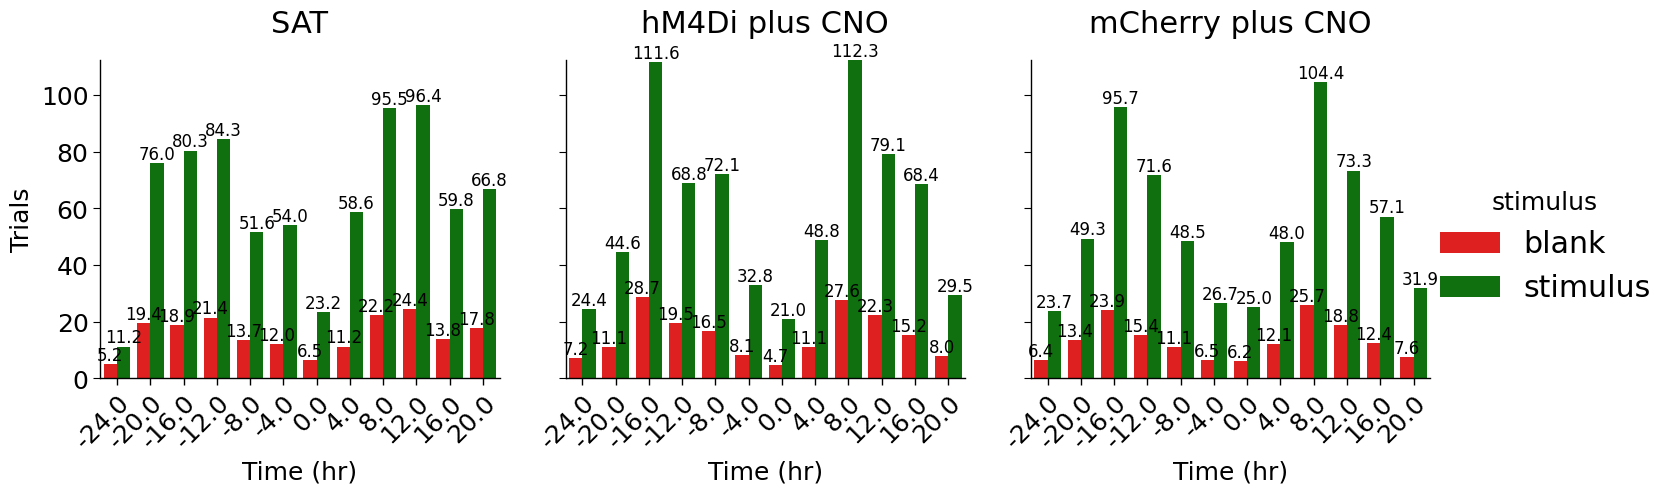

In [ ]:
# bar plot by hour stim and blank
cond = (counts["Time (hr)"] < 24) & (counts["Time (hr)"] >= -24)
g = sns.catplot(counts[cond], x="Time (hr)", y="trial no",
                hue="stimulus", col ="condition", palette = ["red", "green"], 
                kind="bar", errorbar=None)

i=0
plt.rcParams["font.size"] = 12
for (col_val), ax in g.axes_dict.items():
    t=f"{cond_dict[col_val]}"
    ax.set_title(t, fontsize=22)
    ax.tick_params(labelbottom=True, labelsize=18)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    ax.set_ylabel("Trials", fontsize=18)
    ax.set_xlabel("Time (hr)", fontsize=18)
    new_value=0.4 
    for j in range(len(ax.containers)):
        ax.bar_label(ax.containers[j], fmt='%0.1f')
    i += 1
g.figure.subplots_adjust(hspace=0.3)

#### number of stimulus and blank trials as stacked plot (average but no error bars)

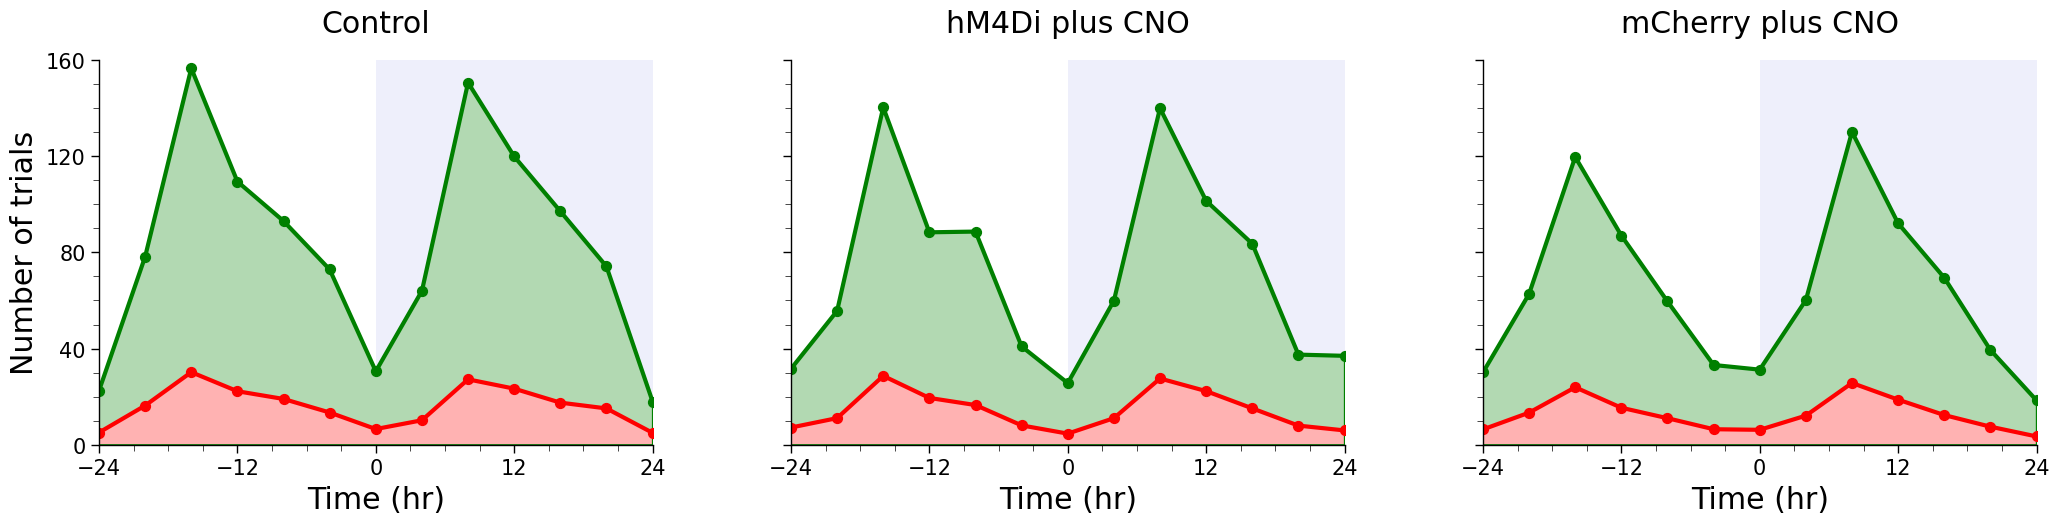

In [ ]:
# number of stimulus and blank trials as stacked plot (average but no error bars)
cond = (counts["Time (hr)"] <= 24) & (counts["Time (hr)"] >= -24)
avg_counts = counts[cond]
avg_counts = avg_counts.groupby(["condition", "Time (hr)", "stimulus"])["trial no"].mean().reset_index()

g, axs = plt.subplots(1, 3, figsize=(25,5))
conds = avg_counts["condition"].unique()

ylims = [0, 160]
xlims = [-24,24]
ymax = ylims[1]

for i in range(len(conds)):
    lab = avg_counts[avg_counts["condition"] == conds[i]]["stimulus"].unique()
    x = avg_counts[(avg_counts["condition"] == conds[i]) & (avg_counts["stimulus"] == lab[0])]["Time (hr)"]
    axs[i].spines[["top", "right"]].set_visible(False)
    y1 = avg_counts[(avg_counts["condition"] == conds[i]) & (avg_counts["stimulus"] == lab[0])]["trial no"].reset_index(drop=True)
    y2 = avg_counts[(avg_counts["condition"] == conds[i]) & (avg_counts["stimulus"] == lab[1])]["trial no"].reset_index(drop=True)
    axs[i].stackplot(x, y1, y2, labels=lab, colors=[blank_fill,stim_fill], alpha=1, edgecolor=["green", "red"])
    axs[i].plot(x, y1, color="red")
    axs[i].scatter(x, y1, color="red", s=50)
    axs[i].plot(x, (y1 + y2),color="green")
    axs[i].scatter(x, (y1 + y2), color="green",s=50)    
    axs[i].add_patch(Rectangle((0, ylims[0]), 24, ylims[1], color=sat_fill, alpha=0.4, 
                                    zorder=0, fill=True, lw=0))
    ylabel="Number of trials"
    axs[i].set_ylim(ylims)
    axs[i].xaxis.set_major_locator(ticker.MultipleLocator(12))
    axs[i].yaxis.set_major_locator(ticker.MultipleLocator(40))
    axs[i].xaxis.set_minor_locator(ticker.MultipleLocator(3))
    axs[i].yaxis.set_minor_locator(ticker.MultipleLocator(10))
    if i == 0:
        style_axes(axs[i], ylims, xlims, ylabel, "Time (hr)", cond_dict[conds[i]], "x-large", "medium")
    else:
       style_axes(axs[i], ylims, xlims, "", "Time (hr)", cond_dict[conds[i]], "x-large", "medium", yticklabels=False) 
    ax.spines[["bottom", "left"]].set(lw=2)
g.subplots_adjust(wspace=0.25)

#### number of trials per bout

In [ ]:
# number of trials per bout
f = data.groupby(["condition", "animal", "Time (hr)", "bout no", "trial no"]).first().reset_index()

counts_prev = f.groupby(["condition","animal", "Time (hr)", "bout no", "stimulus", "1_back"]).count()
cts_gp = counts_prev.groupby(["condition", "animal", "Time (hr)", "stimulus", "1_back"])
mean_prev = cts_gp.mean().reset_index()
total_prev = cts_gp.sum().reset_index()

counts_stim = f.groupby(["condition","animal", "Time (hr)", "bout no", "stimulus"]).count()
cts_gp = counts_stim.groupby(["condition", "animal", "Time (hr)", "stimulus"])
mean_stim = cts_gp.mean().reset_index()
total_stim = cts_gp.sum().reset_index()

counts_all = f.groupby(["condition","animal", "Time (hr)", "bout no"]).count()
mean_all = counts_all.groupby(["condition", "animal", "Time (hr)"]).mean().reset_index()

h = mean_prev[['1_back', 'stimulus']].apply(tuple, axis=1)
p = ["xkcd:burgundy", "xkcd:dark forest green", "xkcd:magenta", "xkcd:turquoise green"]
ordr = [('stimulus', 'blank'),
       ('stimulus', 'stimulus'), ('blank', 'blank'),
       ('blank', 'stimulus')]


#### number of trials by previous trial identity

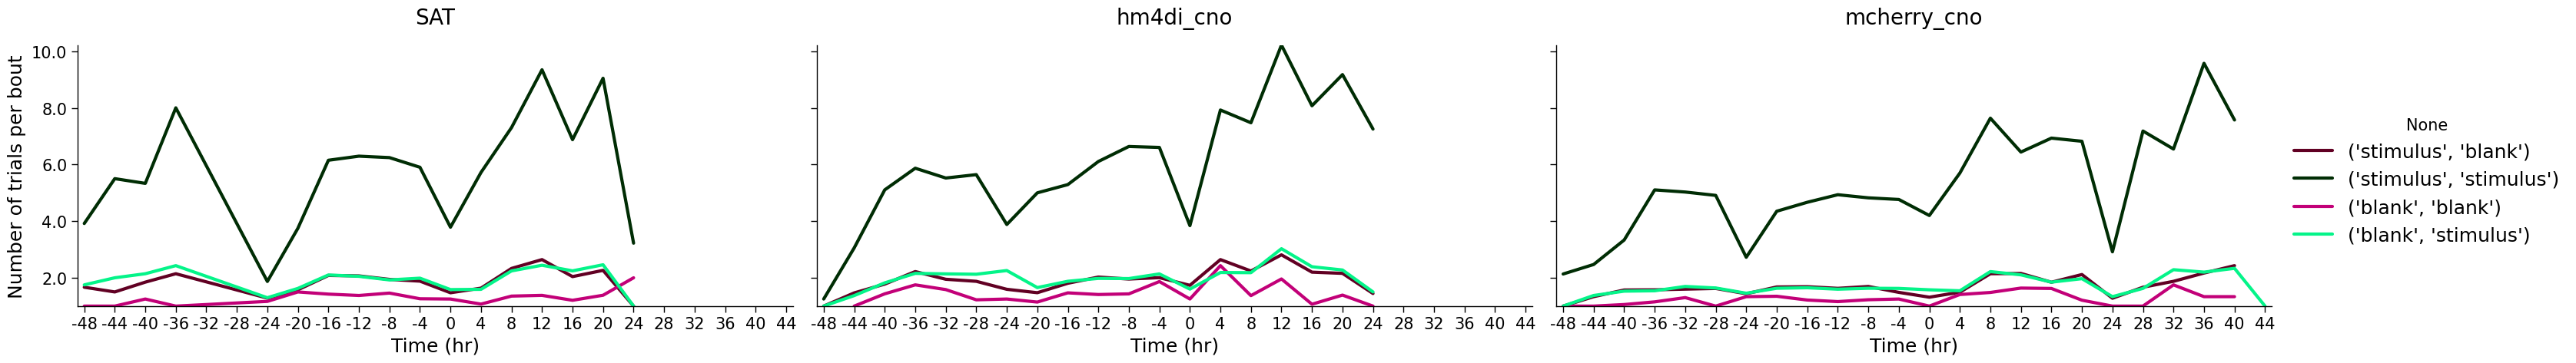

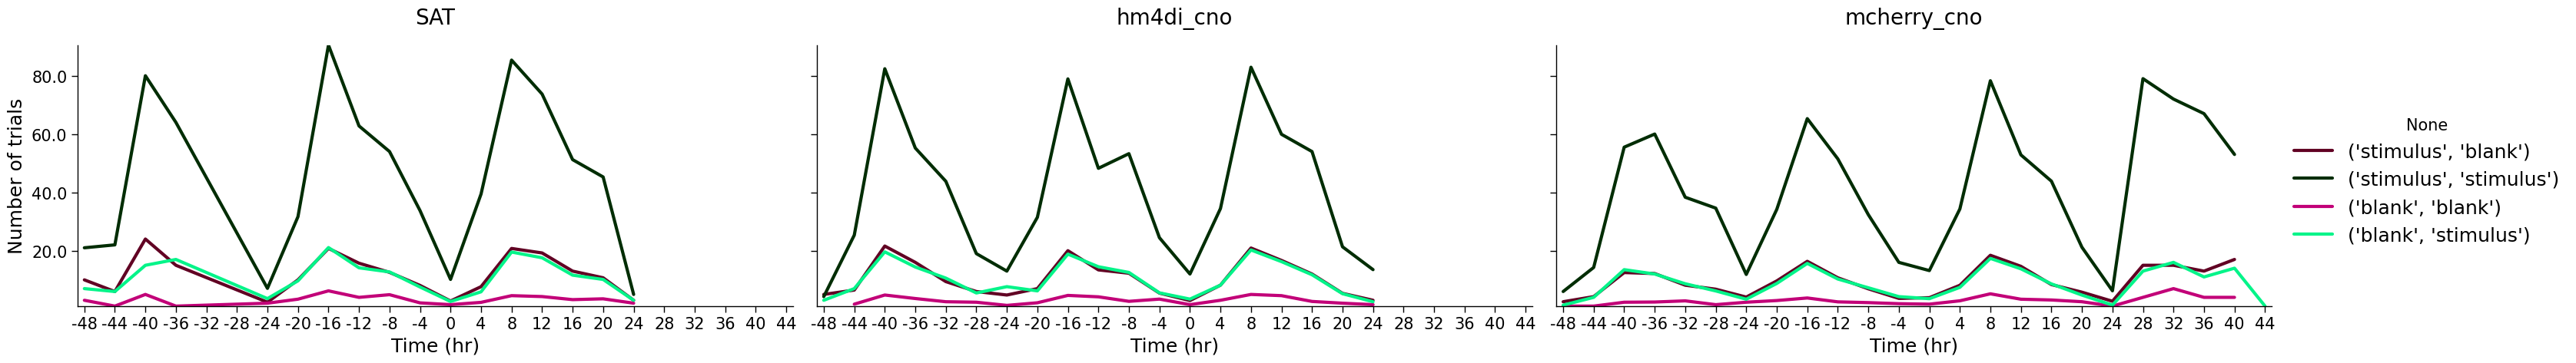

In [ ]:
# number of trials by previous trial identity
g = sns.relplot(data=mean_prev, x="Time (hr)", y="lick", col="condition", hue=h, 
                palette=p, hue_order=ordr, kind="line", errorbar=None, aspect=2)
ticks = [i for i in range(-48, 48, 4)]
for (col_val), ax in g.axes_dict.items():
    ax.set_title(f'{col_val}', fontsize=20)
    ax.set_xlabel("Time (hr)", fontsize=18)
    ax.set_ylabel("Number of trials per bout", fontsize=18)
    ax.set_xticks(ticks)
    ax.set_xticklabels(ticks, ha='center', fontsize=15)
    ax.set_yticklabels(ax.get_yticks(), fontsize=15)

g = sns.relplot(data=total_prev, x="Time (hr)", y="lick", col="condition", hue=h, 
                palette=p, hue_order=ordr,kind="line", errorbar=None, aspect=2)
ticks = [i for i in range(-48, 48, 4)]
for (col_val), ax in g.axes_dict.items():
    ax.set_title(f'{col_val}', fontsize=20)
    ax.set_xlabel("Time (hr)", fontsize=18)
    ax.set_ylabel("Number of trials", fontsize=18)
    ax.set_xticks(ticks)
    ax.set_xticklabels(ticks, ha='center', fontsize=15)
    ax.set_yticklabels(ax.get_yticks(), fontsize=15)

### Bout statistics

#### Calculate bout statistics

In [ ]:
# calculate bout statistics

# metadata
keep = data.groupby(["animal", "bout no"]).last()[["condition", "age", "sex", "strain", "cage", "Time (hr)", "stimulus"]]

# bout length (time of last sample in bout - time of first sample in bout)
bout_start = data.groupby(["animal", "bout no"]).first()["timestamp"] 
bout_end = data.groupby(["animal", "bout no"]).last()["timestamp"]
bout_end_identity = data.groupby(["animal", "bout no"]).last()[["timestamp","stimulus"]]
bout_len = (bout_end - bout_start).rename("bout len")

# intra bout iti (first sample of trial - last sample of previous trial)
intra_bt_trial_start = data.groupby(["animal", "bout no", "trial no"]).first()["timestamp"]
intra_bt_trial_end = data.groupby(["animal", "bout no", "trial no"]).last()["timestamp"]
intra_bt_iti = (intra_bt_trial_start - intra_bt_trial_end.groupby(["animal", "bout no"]).shift()).rename("intra bout iti")
intra_bt_iti = intra_bt_iti.groupby(["animal", "bout no"]).mean()
num_trials = intra_bt_trial_start.groupby(["animal", "bout no"]).count().rename("num trials")

# inter bout interval (first sample in bout - last sample in previous bout)
ibi = (bout_start - bout_end.groupby(["animal"]).shift()).rename("ibi")

# concat stats and metatdata together
bout_stats = pd.concat([keep, bout_len, ibi, intra_bt_iti, num_trials], axis=1).reset_index()

# convert to float
# handle NaT (i.e. first trial in bout for iti and ibi) by setting to -1 then 
# resetting all values less than 1 to NA 
# (hacky, but works because no iti or ibi should ever be < 0)
bout_stats["bout len"] = bout_stats["bout len"].to_numpy(dtype="timedelta64[ms]").astype("float")/(1000.)
bout_stats["ibi"] = bout_stats["ibi"].to_numpy(dtype="timedelta64[m]", na_value=-1).astype("float")/60.
bout_stats.loc[bout_stats["ibi"] < 0,"ibi"] = pd.NA
bout_stats["intra bout iti"] = bout_stats["intra bout iti"].to_numpy(dtype="timedelta64[ms]", na_value=-1).astype("float")/1000.
bout_stats.loc[bout_stats["intra bout iti"] < 0,"intra bout iti"] = pd.NA

# calculate trial frequency (number of trials/length of bout)
bout_stats["frequency"] = bout_stats["num trials"]/bout_stats["bout len"]

#### Bout length

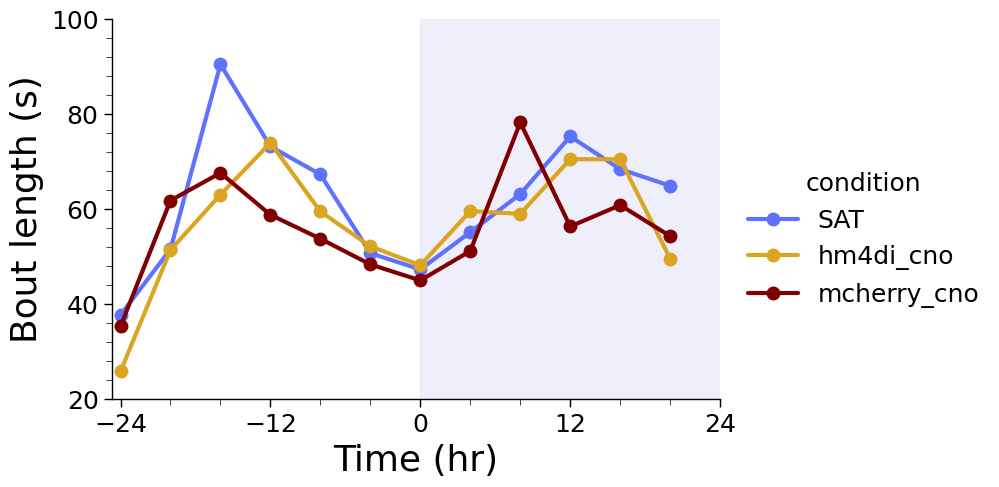

In [ ]:
# Bout length
cond = (bout_stats["Time (hr)"] >= -24) & (bout_stats["Time (hr)"] < 24)
g = sns.relplot(bout_stats[cond], x="Time (hr)", y="bout len", hue="condition", 
                kind="line", errorbar=None, 
                palette=cond_palette, marker="o", mec=None, ms=10,
                hue_order=cond_ordr, aspect=1.5, facet_kws={"sharey":False})
style_relplot_hr(g, [20, 100], "Bout length (s)", cond_dict, label_sat=False,ymultmin=8)
xlims=[-24.7, 24]
ylims = [20,100]
x_mult = 12
y_mult = 20
ax = g.fig.axes[0]
# line at 0
ax.axhline(y=0, xmin=0, xmax=1, ls="-", color="black", zorder=1, lw=1)
ax.add_patch(Rectangle((0, ylims[0]), 24, ylims[1], color=sat_fill, alpha=0.4, 
                        zorder=-1, fill=True))
ax.set_ylim(ylims)                
ax.xaxis.set_major_locator(ticker.MultipleLocator(x_mult))
ax.yaxis.set_major_locator(ticker.MultipleLocator(y_mult))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(x_mult/3))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(y_mult/5))
ax.set_yticks(ax.get_yticks(), labels=np.arange(0, 140, 20), fontsize="medium")
style_axes(ax, ylims, xlims,"Bout length (s)", "Time (hr)", "", "xx-large", "large")

move_leg(g, "large")

#### Inter bout interval

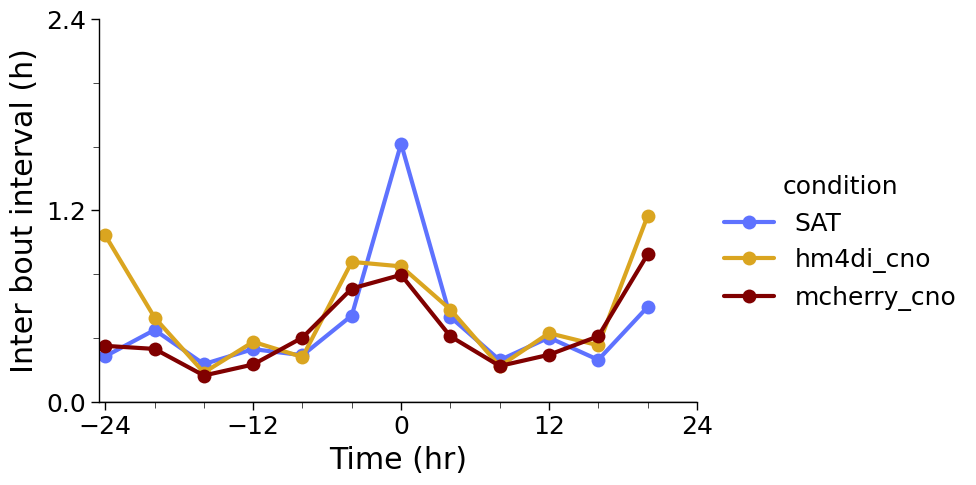

In [ ]:
# Inter bout interval
cond = (bout_stats["Time (hr)"] >= -24) & (bout_stats["Time (hr)"] < 24)

g = sns.relplot(bout_stats[cond], x="Time (hr)", y="ibi", hue="condition", 
                kind="line", errorbar=None, 
                palette=cond_palette, marker="o", mec=None, ms=10,
                facet_kws={"sharey":False},
                hue_order=cond_ordr, aspect=1.5)
g.set(ylabel="inter bout interval (h)")
style_relplot_hr(g, [0, 2.4], "Inter bout interval (h)", cond_dict, label_sat=False)

#### Intra-bout inter trial interval

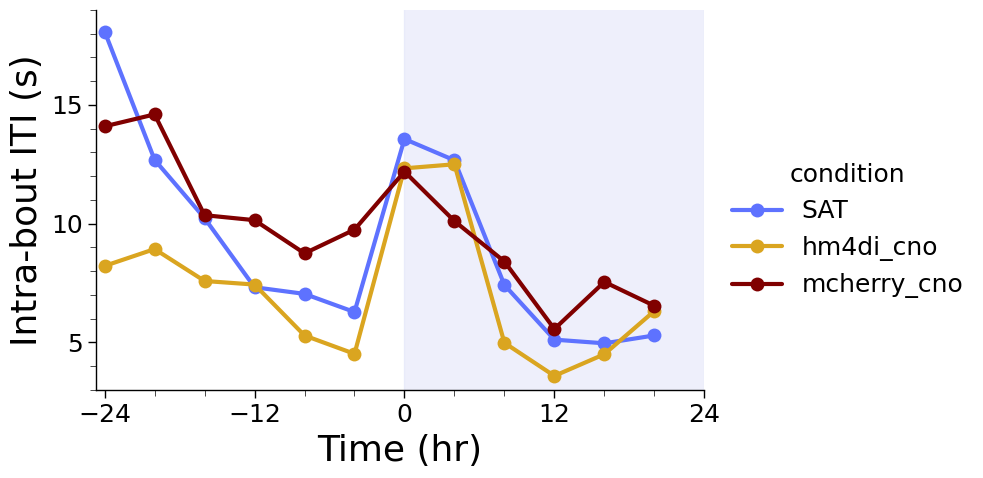

In [ ]:
# intra-bout inter trial interval
g = sns.relplot(bout_stats[cond], x="Time (hr)", y="intra bout iti", 
                hue="condition", kind="line", errorbar=None,
                palette=cond_palette, marker="o", mec=None, ms=10,
                hue_order=cond_ordr, aspect=1.5, facet_kws={"sharey":False})

xlims=[-24.7, 24]
ylims = [3,19]
x_mult = 12
y_mult = 5
ax = g.fig.axes[0]
# line at 0
ax.axhline(y=0, xmin=0, xmax=1, ls="-", color="black", zorder=1, lw=1)
ax.add_patch(Rectangle((0, ylims[0]), 24, ylims[1], color=sat_fill, alpha=0.4, 
                        zorder=-1, fill=True))
ax.set_ylim(ylims)                
ax.xaxis.set_major_locator(ticker.MultipleLocator(x_mult))
ax.yaxis.set_major_locator(ticker.MultipleLocator(y_mult))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(x_mult/3))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(y_mult/5))
style_axes(ax, ylims, xlims,"Intra-bout ITI (s)", "Time (hr)", "", "xx-large", "large")
move_leg(g, "large")

#### Number of trials per bout

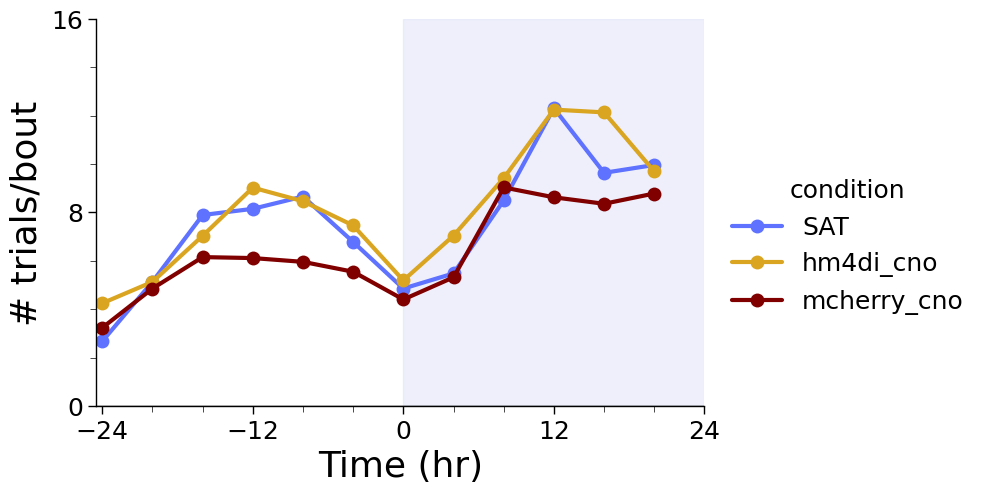

In [ ]:
# number of trials per bout
cond = (bout_stats["Time (hr)"] >= -24) & (bout_stats["Time (hr)"] < 24)

g = sns.relplot(bout_stats[cond], x="Time (hr)", y="num trials", 
                hue="condition", kind="line", errorbar=None, 
                palette=cond_palette, marker="o", mec=None, ms=10,
                hue_order=cond_ordr, aspect=1.5, facet_kws={"sharey":False})
xlims=[-24.5, 24]
ylims = [0,16]
x_mult = 12
y_mult = ylims[1]/2
ax = g.fig.axes[0]
# line at 0
ax.axhline(y=0, xmin=0, xmax=1, ls="-", color="black", zorder=1, lw=1)
ax.add_patch(Rectangle((0, ylims[0]), 24, ylims[1], color=sat_fill, alpha=0.4, 
                        zorder=-1, fill=True))
ax.set_ylim(ylims)                
ax.xaxis.set_major_locator(ticker.MultipleLocator(x_mult))
ax.yaxis.set_major_locator(ticker.MultipleLocator(y_mult))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(x_mult/3))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(y_mult/4))
style_axes(ax, ylims, xlims,"# trials/bout", "Time (hr)", "", "xx-large", "large")
move_leg(g, "large")

#### Intra-bout trial frequency

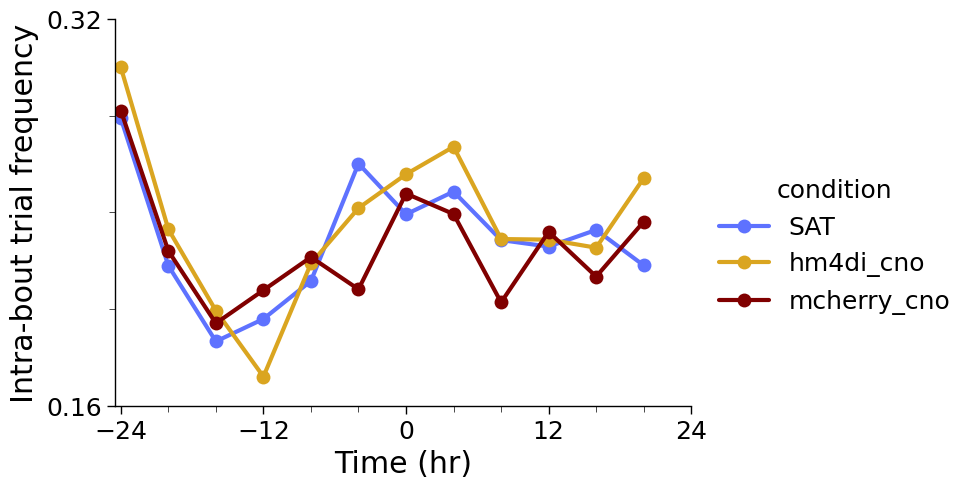

In [ ]:
# Intra-bout trial frequency
g = sns.relplot(bout_stats[cond], x="Time (hr)", y="frequency", hue="condition", 
                kind="line", errorbar=None,
                palette=cond_palette, marker="o", mec=None, ms=10,
                hue_order=cond_ordr,aspect=1.5, facet_kws={"sharey":False})
style_relplot_hr(g, [0.16, 0.32], "Intra-bout trial frequency", cond_dict, label_sat=False,ymultmin=4)

### Lick frequency across trial

####  across trial lick frequency for specific timebins

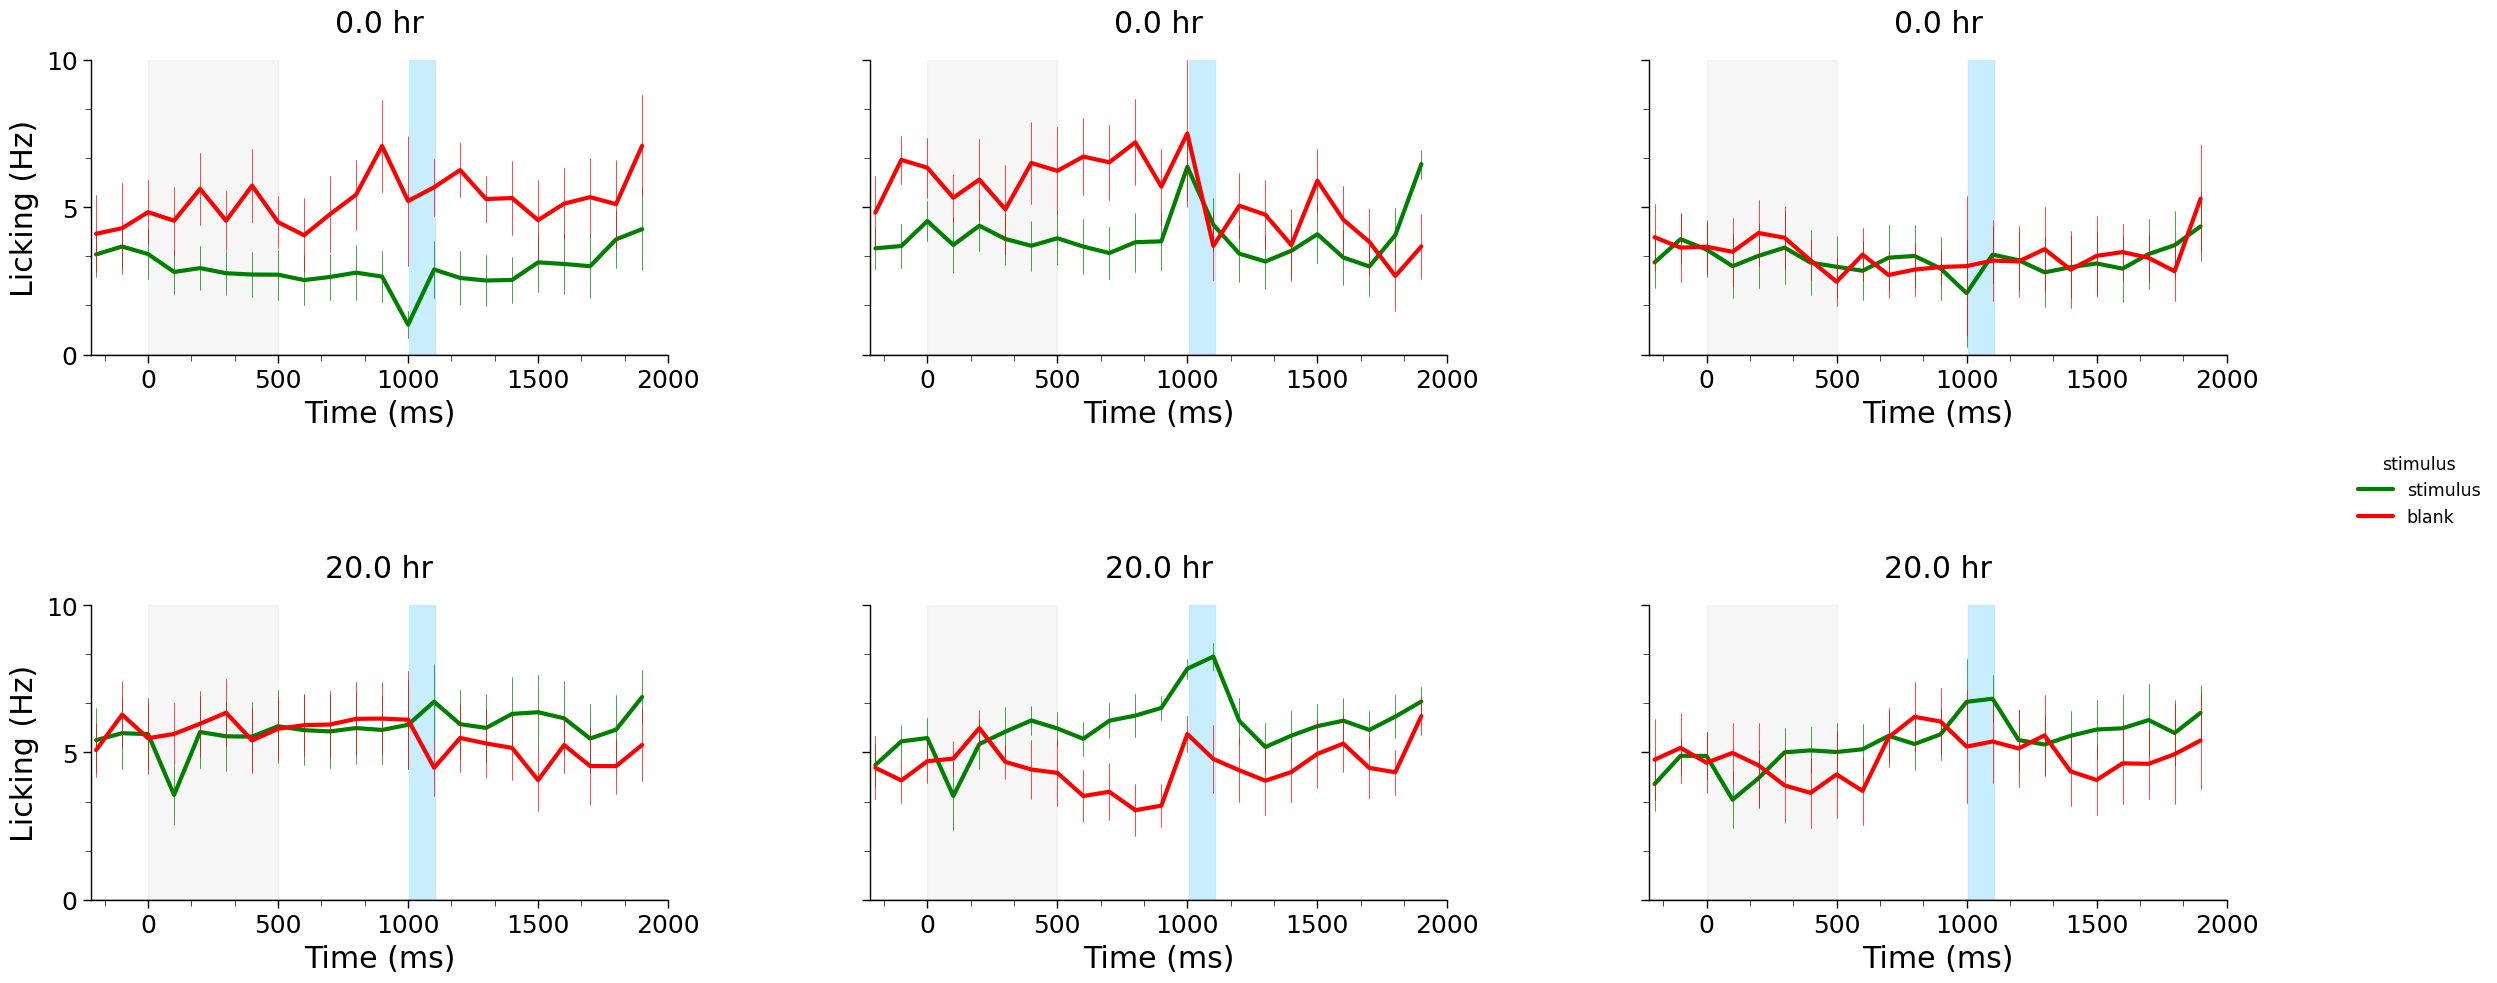

In [ ]:
#  across trial lick frequency
cond = ((mean_statistics["Time (hr)"] == 0) | (mean_statistics["Time (hr)"] == 20))
# plot all timebins average performance trace on the same plot
g = sns.relplot(data=mean_statistics[cond],kind="line",x="Time (ms)", y="lick",
                col="condition", row="Time (hr)", hue="stimulus", 
                palette=["green", "red"], hue_order=["stimulus", "blank"], 
                errorbar="se",err_style="bars", legend="full", aspect=1.5, 
                facet_kws={"sharex":False, "sharey":False}, err_kws={"lw":0.5})

style_relplot_ms(g, [0,10], "Lick Frequency (Hz)", cond_dict)
g.axes_dict[(0.0, "SAT")].set_ylabel("Licking (Hz)")
g.axes_dict[(20.0, "SAT")].set_ylabel("Licking (Hz)")
for i in [0.0, 20.0]:
    plt.setp([g.axes_dict[(i,"mcherry_cno")].get_yticklabels(), g.axes_dict[(i,"hm4di_cno")].get_yticklabels()], visible=False)


#### anticipatory licking by previous trial contingency


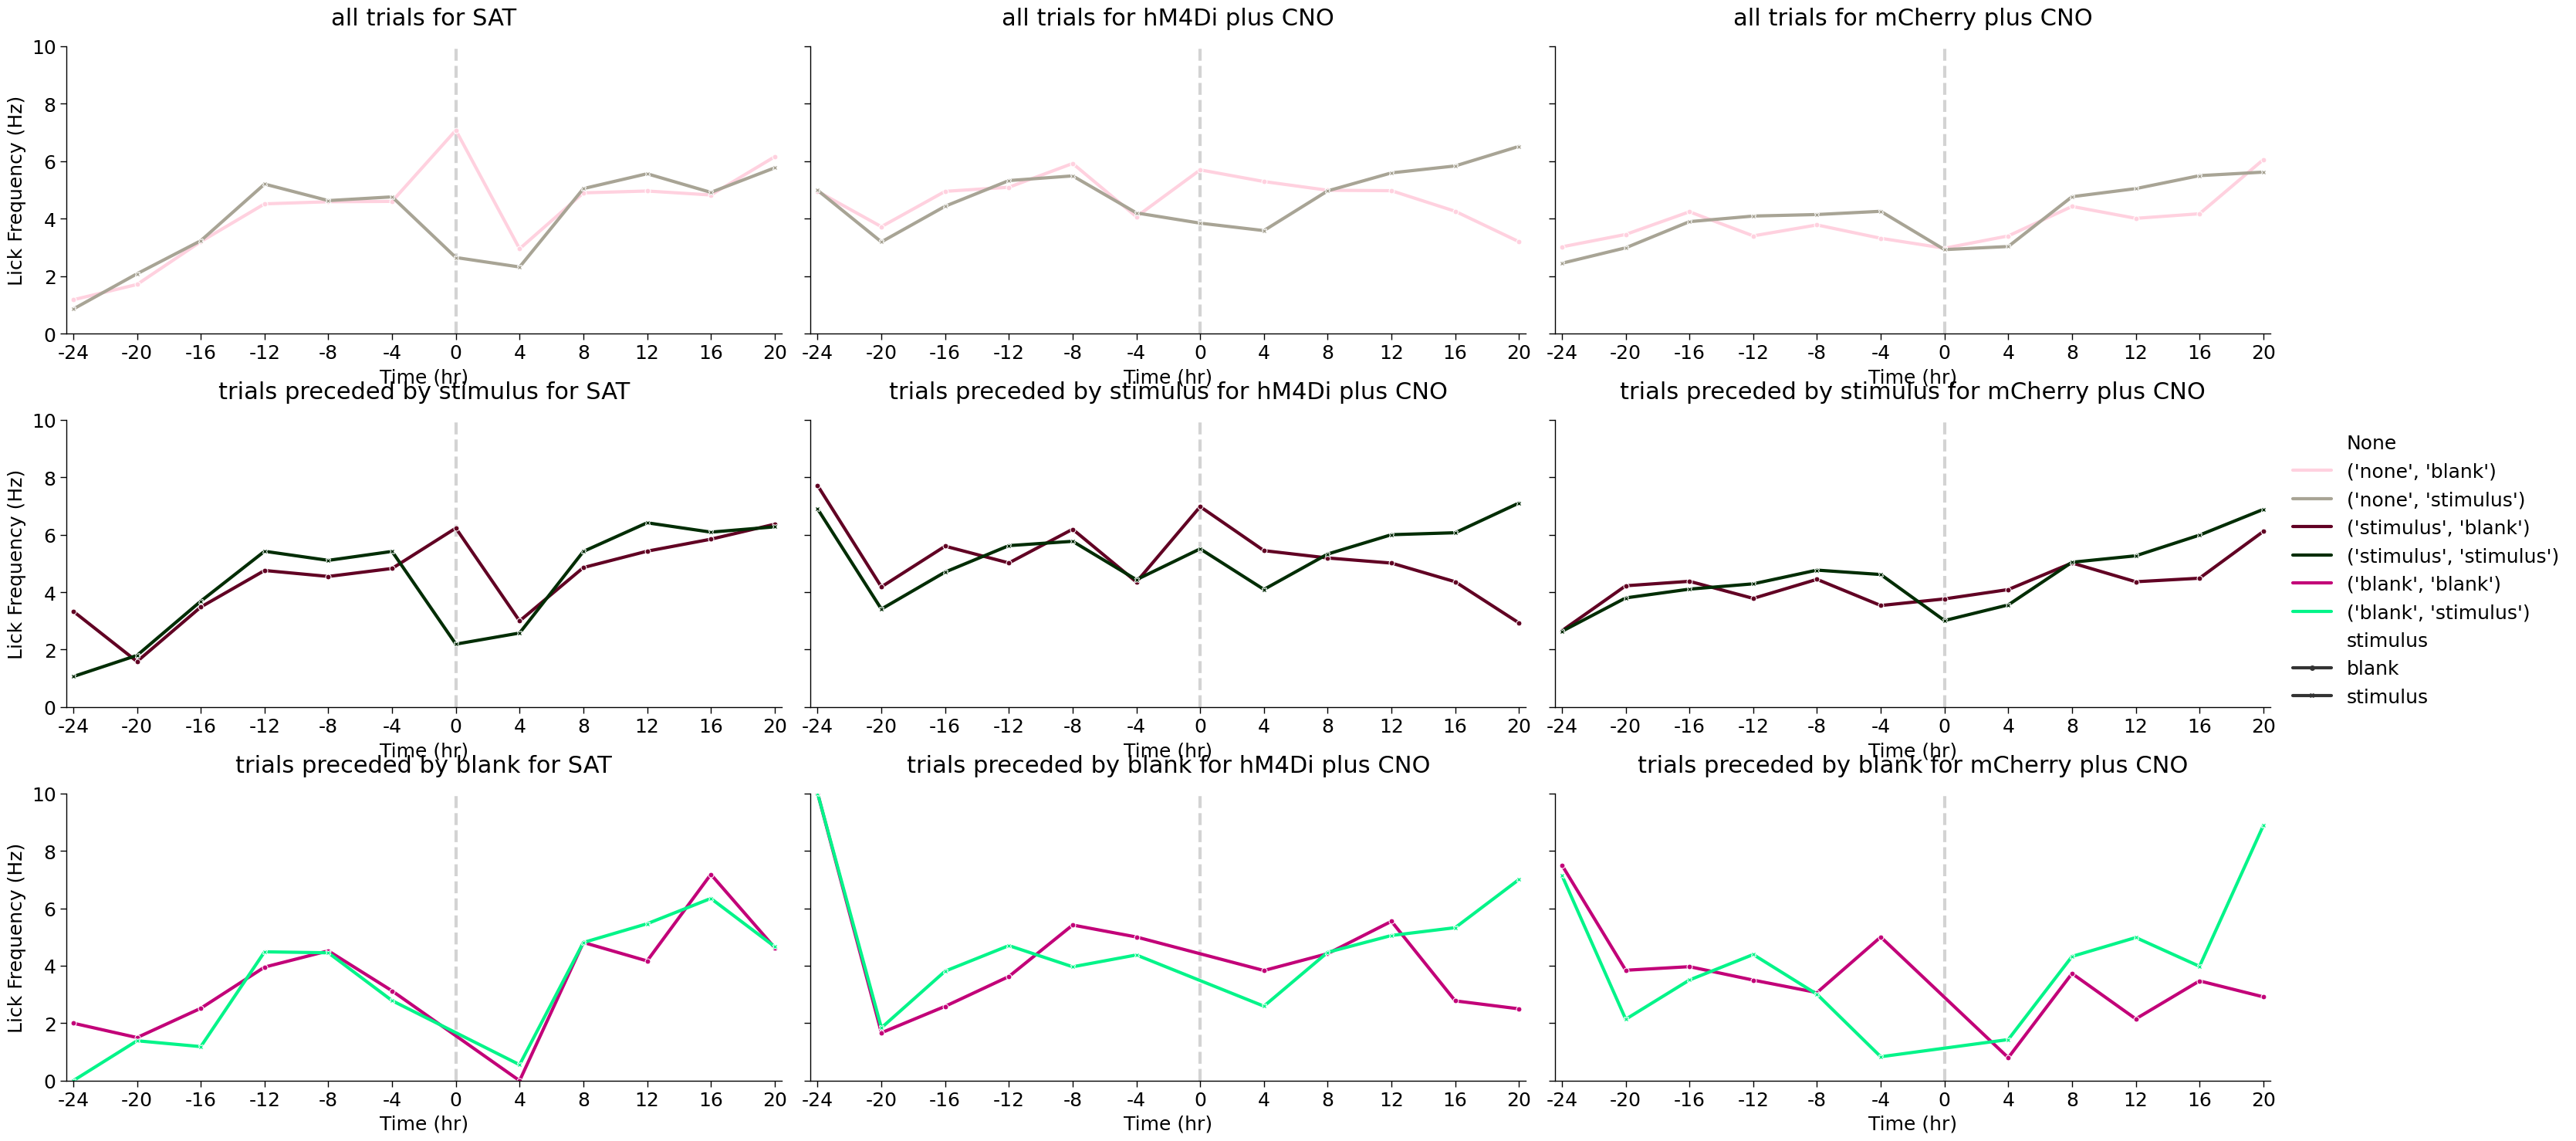

In [ ]:
# anticipatory licking by previous trial contingency
ant = mean_w_prev[(mean_w_prev["Time (ms)"] == 900)] 
cond = (ant["Time (hr)"] < 24) & (ant["Time (hr)"] >= -24) & (ant["n_back"] < 2)

h = ant[cond][['back_type', 'stimulus']].apply(tuple, axis=1)
p = ["xkcd:light pink", "xkcd:greyish", "xkcd:burgundy", "xkcd:dark forest green", "xkcd:magenta", "xkcd:turquoise green"]
ordr = [('none', 'blank'), ('none', 'stimulus'), ('stimulus', 'blank'),
       ('stimulus', 'stimulus'), ('blank', 'blank'),
       ('blank', 'stimulus')]

g = sns.relplot(ant[cond], x="Time (hr)", y="lick", 
                hue=h, col ="condition", row="back_type", palette = p, 
                hue_order=ordr, kind="line", errorbar=None, style="stimulus", 
                dashes=False, markers=True, aspect=2, facet_kws={"sharex":False})

row_dict = {"none":"all trials", "stimulus":"trials preceded by stimulus", "blank":"trials preceded by blank"}
col_dict = {"SAT":"SAT", "all_reward":"100% acclimation, 80% SAT", "hm4di_cno":"hM4Di plus CNO", "mcherry_cno":"mCherry plus CNO"}


ticks = [i for i in range(-24, 24, 4)]
for (row_val, col_val), ax in g.axes_dict.items():
    t = f'{row_dict[row_val]} for {col_dict[col_val]}'
    ax.set_title(t, fontsize=22)
    ax.axvline(x=0, ymin=0, ymax=1, ls="--", color="lightgrey", zorder=0)
    ax.set_xticks(ticks)
    ax.set_xticklabels(ticks, ha='center')
    ax.tick_params(labelbottom=True, labelsize=18)
    ax.set_ylabel("Lick Frequency (Hz)", fontsize=18)
    ax.set_xlabel("Time (hr)", fontsize=18)
g.figure.subplots_adjust(hspace=0.3)

#### anticipatory licking by previous trial contingency blank vs blank and stim vs stim


[None, None, None, None]

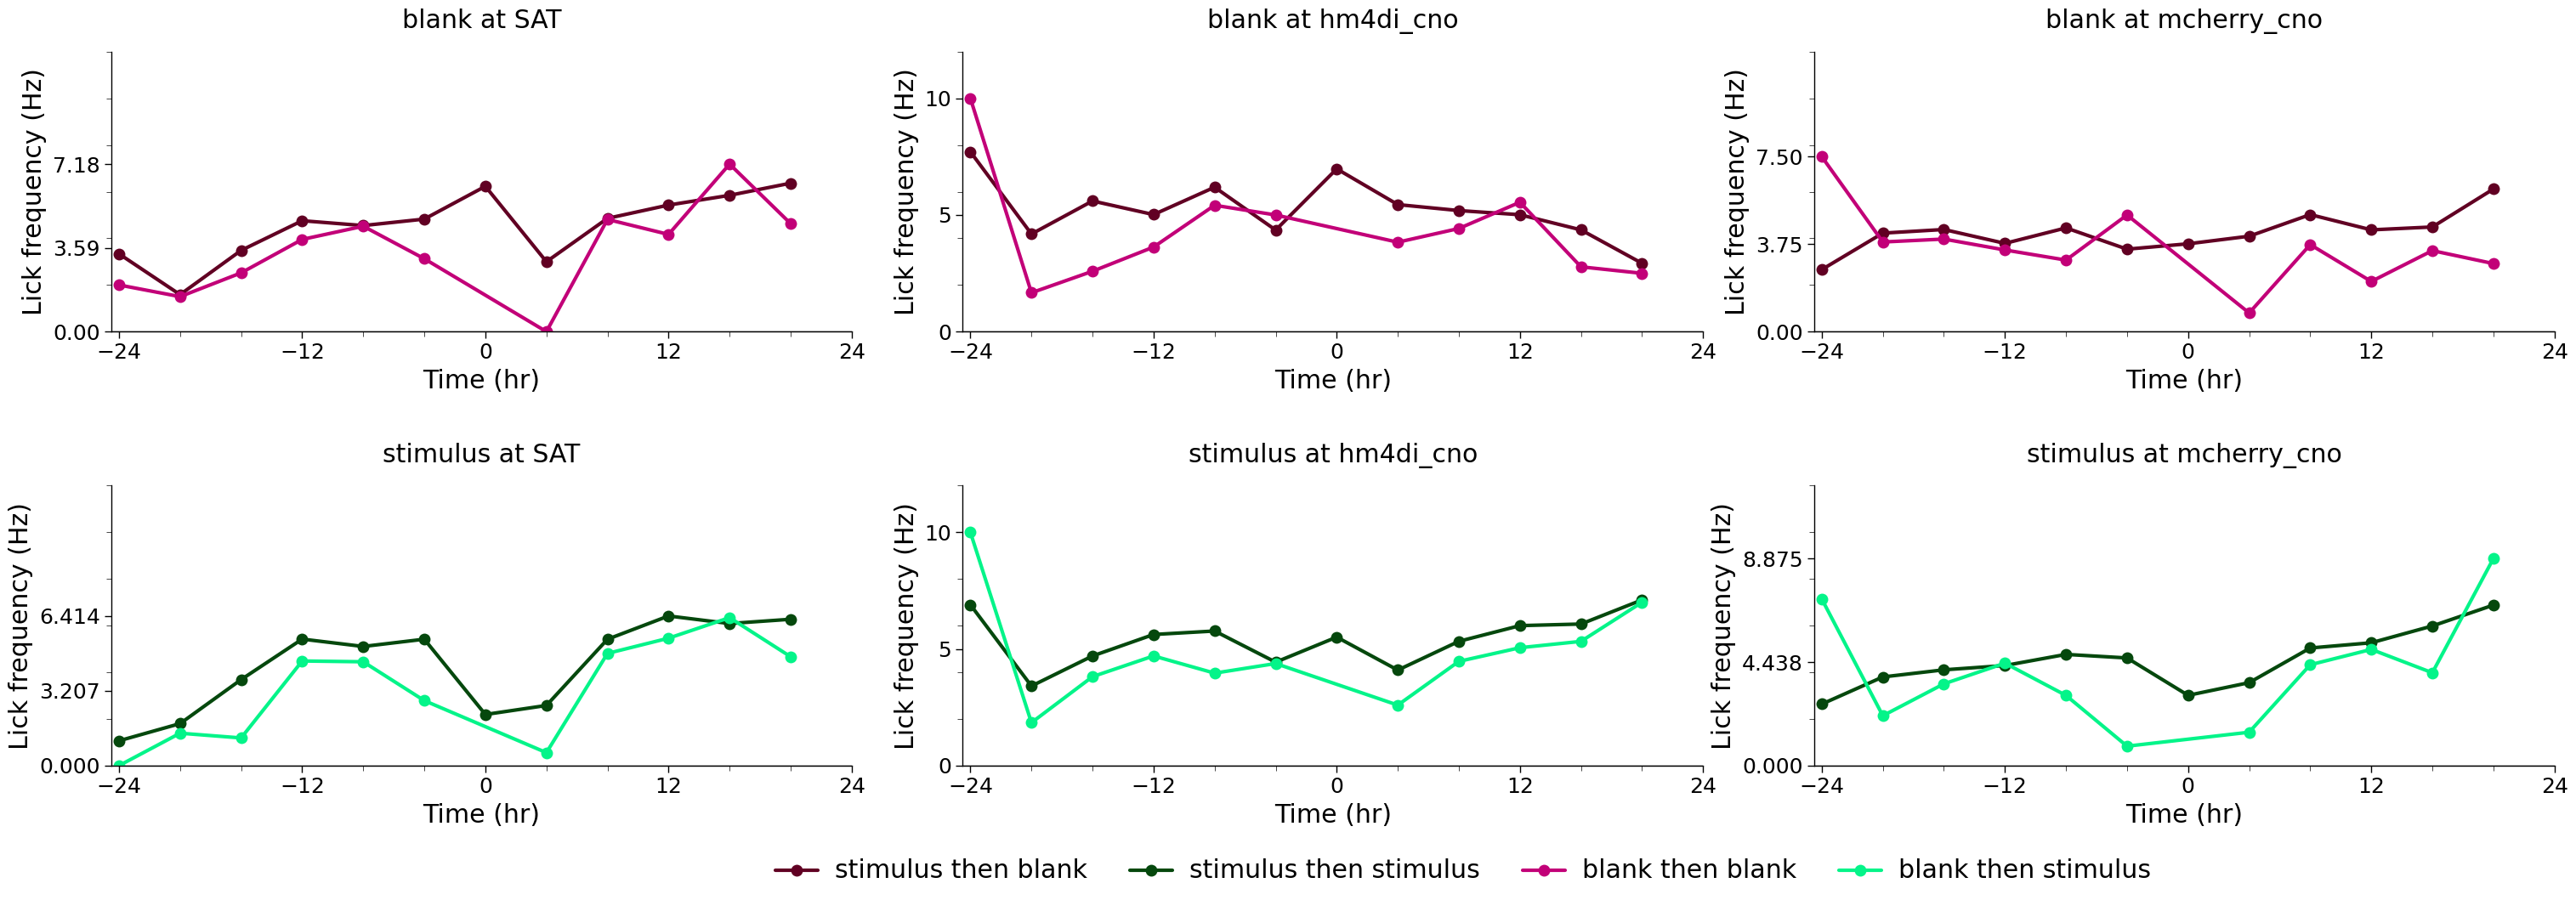

In [ ]:
# anticipstory licking by previous trial contingency blank vs blank and stim vs stim
ant = mean_w_prev[(mean_w_prev["Time (ms)"] == 900)] 

cond = (ant["Time (hr)"] < 24) & (ant["Time (hr)"] >= -24) & (ant["n_back"] < 2) & (ant["back_type"] != "none")

h = ant[cond][['back_type', 'stimulus']].apply(tuple, axis=1)
g = sns.relplot(ant[cond], x="Time (hr)", y="lick", 
                hue=h, col ="condition", row="stimulus", palette = prev_palette, 
                hue_order=prev_ordr, kind="line", errorbar=None, 
                aspect=2, facet_kws={"sharex":False, "sharey":False},
                marker='o', mec=None, ms=10)


style_relplot_hr(g, [0, 12], "Lick frequency (Hz)", prev_dict, label_sat=False)

row_dict = {"stimulus":"stimulus trials", "blank":"blank trials"}
col_dict = {"SAT":"SAT", "all_reward":"100% acclimation, 80% SAT", "hm4di_cno":"hM4Di plus CNO", "mcherry_cno":"mCherry plus CNO"}


ticks = [i for i in range(-24, 24, 4)]
for (row_val, col_val), ax in g.axes_dict.items():
    t = f'{row_dict[row_val]} for {col_dict[col_val]}'
    
new_texts = {"('stimulus', 'blank')":"stimulus then blank",
       "('stimulus', 'stimulus')":"stimulus then stimulus", "('blank', 'blank')":"blank then blank",
       "('blank', 'stimulus')":"blank then stimulus"}
for t in g._legend.get_texts():
    t.set_text(new_texts[t.get_text()])

sns.move_legend(g, "lower center", ncol=5, bbox_to_anchor=(0.5,-0.07),title=None)
plt.setp(g._legend.get_texts(), fontsize='x-large')



### Raster of trial timing (one animal)

Text(0.5, 0, 'Time (min)')

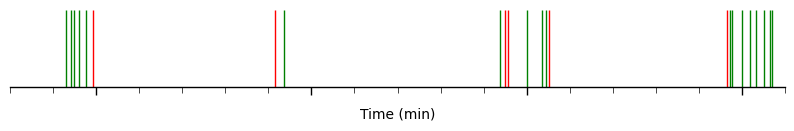

In [ ]:
# raster for one animal
lwp2 = data[(data["animal"] == "LWP2")]
lwp2 = lwp2.groupby("trial no").first().reset_index()
start = datetime.datetime(year=2022, month=2, day=5, hour=19, minute=53)
end = datetime.datetime(year=2022, month=2, day=5, hour=20, minute=11)
lwp2 = lwp2[(lwp2["timestamp"] >= start) & (lwp2["timestamp"] <= end)].reset_index(drop=True)
lwp2["relative time"] = lwp2["timestamp"] - lwp2["timestamp"][0]
lwp2 = time_to_float(lwp2, "relative time", "relative time", "ms")
lwp2["relative time"] = lwp2["relative time"]/(1000.*60.)
gps = []
for gname, gp in lwp2.groupby(["stimulus"]):
    gps.append(gp["timestamp"])

fig, ax = plt.subplots(1, 1, figsize=(10,1))
c = ["red", "green"]

lo = [0,0]
lw = [1,1]
ll = 1

ax.eventplot(positions=gps, colors=c, lineoffsets=lo, linewidths=lw, linelengths=ll) 
ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=5))
ax.xaxis.set_minor_locator(mdates.MinuteLocator(interval=1))  
ax.xaxis.set_major_formatter(ticker.NullFormatter())

ax.set_ylim([-0.5,0.5])
ax.set_xlim([start,end])

ax.spines[["left", "right", "top"]].set(visible=False)
ax.yaxis.set_major_locator(ticker.NullLocator())
ax.set_xlabel("Time (min)", fontsize='10')



# 8. Statistical Tests

### Number of trials

#### By day

In [ ]:
# number of trials
total_trials = total_trials[(total_trials["Day"] == 0) | (total_trials["Day"] == -1)]
satcond = (total_trials["condition"]=="SAT")
allcond = (total_trials["condition"]=="all_reward")
hcond = (total_trials["condition"]=="hm4di_cno")
mcond = (total_trials["condition"]=="mcherry_cno")

tests = []
ftest = []
for d in total_trials["Day"].unique():
    dcond = total_trials["Day"] == d
    sat = total_trials[satcond & dcond]["trial no"]
    hc = total_trials[hcond & dcond]["trial no"]
    mc = total_trials[mcond & dcond]["trial no"]

    t = stats.ttest_ind(sat, hc, equal_var=False)
    tests.append((t.statistic, t.pvalue))

    t = stats.ttest_ind(sat, mc, equal_var=False)
    tests.append((t.statistic, t.pvalue))

    t = stats.ttest_ind(hc, mc, equal_var=False)
    tests.append((t.statistic, t.pvalue))

    f = stats.f_oneway(sat, hc, mc)
    ftest.append((f.statistic, f.pvalue))

td = pd.DataFrame(tests).rename(columns={0:"statistic", 1:"pvalue"})
ft = pd.DataFrame(ftest).rename(columns={0:"statistic", 1:"pvalue"})
ft['Day'] = total_trials["Day"].unique()
ft = ft.set_index('Day')
pair = ["sat, hm4di", "sat, mcherry", "mcherry, hm4di"]

indd = pd.MultiIndex.from_product([total_trials["Day"].unique(), pair], names=["Time (hr)", "stimulus"])
td = td.set_index(indd)
td

statistic    pvalue
Time (hr) stimulus                           
 0.0      sat, hm4di      -0.570734  0.574624
          sat, mcherry     0.231773  0.819553
          mcherry, hm4di   1.551160  0.137195
-1.0      sat, hm4di       0.547877  0.590965
          sat, mcherry     1.108307  0.284124
          mcherry, hm4di   1.120153  0.274277

In [ ]:
ft

,statistic,pvalue
Day,,
0.0,0.383726,0.683928
-1.0,0.794551,0.459341


#### By timebin

In [ ]:
# number of stimulus or blank trials in a bin is not statistially different
satcond = (counts["condition"]=="SAT")
allcond = (counts["condition"]=="all_reward")
hcond = (counts["condition"]=="hm4di_cno")
mcond = (counts["condition"]=="mcherry_cno")

ttests_sat = []
ttests_hm4di = []
for i in range (-24, 24, 4):
    timecond = (counts["Time (hr)"] == i)
    for stim in ["blank", "stimulus"]:
        stimcond = (counts["stimulus"] == stim) & timecond
        sat = counts[satcond & stimcond]["trial no"]
        hc = counts[hcond & stimcond]["trial no"]
        mc = counts[mcond & stimcond]["trial no"]
        test_sat = stats.f_oneway(sat, hc, mc)
        ttests_sat.append((test_sat.statistic, test_sat.pvalue))

indd = pd.MultiIndex.from_product([np.arange(-24, 24, 4), ["blank", "stimulus"]], names=["Time (hr)", "stimulus"])
ttests_sat = pd.DataFrame(ttests_sat).rename(columns={0:"statistic", 1:"pvalue"}).set_index(indd)

In [ ]:
ttests_sat[ttests_sat["pvalue"] < 0.05]

statistic    pvalue
Time (hr) stimulus                     
-4        blank      4.475837  0.020951
          stimulus   4.323388  0.023504

### Performance

#### For all timebins, across all groups

In [ ]:
# anticipatory performance is significantly different at t = 20 and t = 0
# SAT is underpowered though (n4 at t=0 and n5 at t=20)
ant = ant_perf
satcond = (ant["condition"]=="SAT")
allcond = (ant["condition"]=="all_reward")
hcond = (ant["condition"]=="hm4di_cno")
mcond = (ant["condition"]=="mcherry_cno")

kr = []
for i in range(-24, 24, 4):
    timecond = (ant["Time (hr)"] == i) 
    sat = ant[satcond & timecond]["lick"]
    hc = ant[hcond & timecond]["lick"]
    mc = ant[mcond & timecond]["lick"]
    krtest = stats.f_oneway(sat, hc, mc)
    kr.append((krtest.statistic, krtest.pvalue))

kr = pd.DataFrame(kr).rename(columns={0:"statistic", 1:"pvalue"})
kr["Time (hr)"] = np.arange(-24, 24, 4)
kr = kr.set_index("Time (hr)")

In [ ]:
kr[kr["pvalue"] < 0.05]

,statistic,pvalue
Time (hr),,
0,4.308404,0.027049
20,5.925225,0.009112


#### Between pairs, at t=0

In [ ]:
# CNO significantly has no response to puff
# hm4di + CNO recovers response to that of normal non-CNO animal
timecond = ant["Time (hr)"] == 0 
sat = ant[satcond & timecond]["lick"]
hc = ant[hcond & timecond]["lick"]
mc = ant[mcond & timecond]["lick"]
tests = []

t = stats.ttest_ind(sat, hc, equal_var=False)
tests.append((t.statistic, t.pvalue))

t = stats.ttest_ind(sat, mc, equal_var=False)
tests.append((t.statistic, t.pvalue))

t = stats.ttest_ind(hc, mc, equal_var=False)
tests.append((t.statistic, t.pvalue))

td = pd.DataFrame(tests).rename(columns={0:"statistic", 1:"pvalue"})
td["pair"] = ["sat, hm4di", "sat, mcherry", "mcherry, hm4di"]
td = td.set_index("pair")
td

,statistic,pvalue
pair,,
"sat, hm4di",-0.338870,0.739906
"sat, mcherry",-3.425021,0.004999
"mcherry, hm4di",-2.364795,0.034730


#### Between pairs, at t=16

In [ ]:
# although means are quite different at t=16, they are not significantly different
timecond = ant["Time (hr)"] == 16
sat = ant[satcond & timecond]["lick"]
hc = ant[hcond & timecond]["lick"]
mc = ant[mcond & timecond]["lick"]
tests = []

t = stats.ttest_ind(sat, hc, equal_var=False)
tests.append((t.statistic, t.pvalue))

t = stats.ttest_ind(sat, mc, equal_var=False)
tests.append((t.statistic, t.pvalue))

t = stats.ttest_ind(hc, mc, equal_var=False)
tests.append((t.statistic, t.pvalue))

td = pd.DataFrame(tests).rename(columns={0:"statistic", 1:"pvalue"})
td["pair"] = ["sat, hm4di", "sat, mcherry", "mcherry, hm4di"]
td = td.set_index("pair")
td

,statistic,pvalue
pair,,
"sat, hm4di",-0.712447,0.483676
"sat, mcherry",-0.914831,0.370846
"mcherry, hm4di",-0.102407,0.919425


#### Between pairs, at t=20

In [ ]:
# mCherry and SAT learning is the same at 20h
# hm4di significantly higher than either
timecond = ant["Time (hr)"] == 20 
sat = ant[satcond & timecond]["lick"]
hc = ant[hcond & timecond]["lick"]
mc = ant[mcond & timecond]["lick"]
tests = []

t = stats.ttest_ind(sat, hc, equal_var=False)
tests.append((t.statistic, t.pvalue))

t = stats.ttest_ind(sat, mc, equal_var=False)
tests.append((t.statistic, t.pvalue))

t = stats.ttest_ind(hc, mc, equal_var=False)
tests.append((t.statistic, t.pvalue))

td = pd.DataFrame(tests).rename(columns={0:"statistic", 1:"pvalue"})
td["pair"] = ["sat, hm4di", "sat, mcherry", "mcherry, hm4di"]
td = td.set_index("pair")
td

,statistic,pvalue
pair,,
"sat, hm4di",-4.411744,0.000865
"sat, mcherry",0.327166,0.749313
"mcherry, hm4di",3.030308,0.011934


# 9. Output Results 

In [ ]:
# # TODO: output raw data
# # TODO: output parameters as metadata 
# analysis_directory = 'C:\\Users\\swind\\Documents\\lab_work\\Barth\\behavior_analysis\\Eunsol_data\\refactor_4h'


# output_dir = f'{analysis_directory}/all_conditions'

# cols = ["condition", "animal", "stimulus", "Time (hr)", "Time (ms)", "lick"]
# mean_statistics.to_excel(f'{output_dir}_lick_frequency.xlsx', columns=cols, index=False)

# cols = ["condition", "animal", "Time (hr)", "stimulus", "trial no"]
# counts.to_excel(f'{output_dir}_trial_counts.xlsx', columns=cols, index=False)

# cols = ["condition", "animal", "Time (hr)", "Time (ms)", "lick"]
# perf.to_excel(f'{output_dir}_performance.xlsx', columns=cols, index=False)


# # full data has too many lines to output to excel with all four conditions
# # takes like 1m 30s to output to csv
# data.to_csv(f'{output_dir}_lickfrequency.csv', index=False)

# 10. Pipeline description

__Pipeline:__

>```
>raw data (csv) ------------|    loader.py                                                     lickfreq_analysis                                            
>                            |------------------> formatted data - many animals (dataframe) ---------------------------> trial-level analysis(dataframe)
>metadata (excel) ----------|
>
>                                     aggregate_analysis   |---> trial number counts by timebin and condition (dataframe) ---|
>trial-level analysis (dataframe) ------------------------|---> mean lick frequency by timebin (dataframe) -----------------|---> plots
>                                                          |---> performance by timebin (dataframe) -------------------------|
>```

***

__Formats__

*raw data*

>time (ms), poke, lick, condition code, delay, stimulus

- time measured from start of file
- poke in {0, 1}
- lick in {0, 2}
- condition code in {3, 4, 5, 7, 9}
    - 3 = delay
    - 4 = air delivery
    - 5 = water delivery
    - 7 = after water delivery
    - 9 = blank
- 200 <= delay <= 800
- stimulus in {0, 1}
    - stimulus not present in SAT code
    - stimulus present and relevant in pseudo code

*metadata*

- excel
- must include 'Animal ID' (3 letter + number animal code)
- must include 'acc' (time of acclimation in days)
- other example columns: age, sex, strain

*formatted data*

>timestamp, poke, lick, condition code, delay, trial no, water, stimulus, animal, condition, metadata

- metadata can be multiple columns

*trial-level analysis*
> condition, animal, trial no, puff delta, trial start, timestamp, metadata, stimulus, water, lick, poke, delta, time (hr), time (ms)

- puff delta is equivalent to time (ms)
    - represents timestamp normalized to air delivery
    - puff delta is timedelta and time (ms) is float
- trial start represents timebin as timestamp
- delta is equivalent to time (hr)
    - represents timebin normalized to start of stat
    - delta is timedelta and time (hr) is float
- metadata can be multiple columns
- lick and poke now represent frequencys aggregated based on given window size

